# BigData_Project

小组成员：

11911808 刘仁杰 Task 1、2、3

11811815 逯济辰 Task 2、4、5

## Background introduction

__犯罪是现代人类社会普遍存在的社会问题。它与经济、文化、政治、技术和人们的幸福有很大关系。__

本次数据分析所采用的数据集有：

* DC_Crime--DC犯罪地理信息数据集

* DC_Properties--DC经济信息数据集

* Neighborhood_Clusters--DC地理特征数据集

我们将从这三个数据集中发现数据的内在特征，数据之间的相关性，找到数据的未来发展趋势，最终得到可靠的数据预测模型。

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pylab as pl
import geopandas
from shapely import geometry
from tqdm import tqdm
from statsmodels.tsa.api import Holt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import json
import geopandas as gpd
import folium
from folium import plugins
import branca
import datetime
import calendar
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

In [146]:
crime = pd.read_csv(r"./data/DC_Crime.csv", low_memory=False)

In [26]:
df = pd.read_csv(r"./data/DC_Properties.csv", low_memory=False)
housing = df

# Task 1 DC Cluster Geo Information

在这次的数据分析中，我们为了满足数据可视化的需要，在给定数据集之外找到了DC特区cluster地理信息数据集，格式为geojson，具体来源自[Open Data DC](https://opendata.dc.gov/datasets/f6c703ebe2534fc3800609a07bad8f5b_17/explore)。

In [4]:
dc = gpd.read_file("./data/Neighborhood_Clusters.geojson")
geo = dc

# Task 2 Data Exploration

## 数据初识

初步查看数据特征，数据分布，缺失值，数值型特征和非数值型特征。

In [4]:
crime.sample(5)

NEIGHBORHOOD_CLUSTER  CENSUS_TRACT offensegroup  LONGITUDE  \
154688           cluster 17        1804.0     property -77.029724   
22199             cluster 2        2801.0      violent -77.035087   
299929           cluster 38        7404.0     property -76.979656   
397759            cluster 3        4400.0     property -77.029634   
79077             cluster 6       10700.0     property -77.040580   

                       END_DATE         offense-text    SHIFT    YBLOCK  \
154688  2008-02-11T12:45:00.000          theft/other  evening  144146.0   
22199   2013-10-14T09:51:00.000              robbery      day  141060.0   
299929  2013-08-21T08:00:00.000          theft/other      day  131285.0   
397759  2017-02-17T17:20:00.000         theft f/auto  evening  138674.0   
79077   2009-11-06T10:30:00.000  motor vehicle theft      day  137054.0   

        DISTRICT  WARD  ...                                    BLOCK  \
154688       4.0   4.0  ...     6118  - 6199 block of 13th street nw   
22199        4.0   1.0  ...     1414  - 1599 block of spring road nw   
299929       7.0   8.0  ...  1730 - 1763 block of stanton terrace se   
397759       3.0   1.0  ...      1900 - 1917 block of 13th street nw   
79077        3.0   2.0  ...         1700 - 1799 block of i street nw   

                     START_DATE       CCN              OFFENSE  \
154688  2008-02-11T12:00:00.000   8019263          theft/other   
22199   2013-10-13T23:00:00.000  13147699              robbery   
299929  2013-08-15T08:00:00.000  13120441          theft/other   
397759  2017-02-17T14:30:37.000  17027518         theft f/auto   
79077   2009-11-06T07:30:00.000   9159438  motor vehicle theft   

        OCTO_RECORD_ID  ANC                REPORT_DAT  METHOD  \
154688     08019263-01   4A  2008-02-11T20:50:00.000Z  others   
22199      13147699-01   1A  2013-10-14T13:51:00.000Z  others   
299929     13120441-01   8E  2013-08-24T15:00:00.000Z  others   
397759     17027518-01   1B  2017-02-17T22:49:22.000Z  others   
79077      09159438-01   2B  2009-11-06T19:30:00.000Z  others   

                                      location   LATITUDE  
154688   38.965230435026072,-77.02972609926789  38.965223  
22199   38.937429413562377,-77.035089466757483  38.937422  
299929  38.849376092601695,-76.979657925284755  38.849368  
397759  38.915937079881559,-77.029636367260366  38.915929  
79077   38.901340268493904,-77.040582294387264  38.901332  

[5 rows x 29 columns]

In [27]:
housing.sample(5)

Unnamed: 0  BATHRM  HF_BATHRM        HEAT AC  NUM_UNITS  ROOMS  BEDRM  \
81295        81295       1          1  Forced Air  Y        1.0      6      3   
153214      153214       1          0   Warm Cool  Y        NaN      3      0   
119927      119927       2          0     Ht Pump  Y        NaN      4      2   
158714      158714       2          0   Warm Cool  Y        NaN      5      2   
146677      146677       2          1     Ht Pump  Y        NaN      7      2   

           AYB  YR_RMDL  ...  LONGITUDE       ASSESSMENT_NBHD  \
81295   1900.0   2008.0  ... -76.975344            Old City 1   
153214  1960.0      NaN  ... -77.056483          Forest Hills   
119927  1911.0   1980.0  ... -77.040092            Old City 2   
158714  1967.0      NaN  ... -77.016301  Southwest Waterfront   
146677  1985.0      NaN  ... -77.065139            Georgetown   

       ASSESSMENT_SUBNBHD  CENSUS_TRACT CENSUS_BLOCK    WARD  SQUARE  \
81295    039 H Old City 1        7903.0  007903 1007  Ward 7    4525   
153214                NaN        1302.0          NaN  Ward 3    2215   
119927   040 D Old City 2        4201.0          NaN  Ward 2    0151   
158714                NaN       11000.0          NaN  Ward 6    0546   
146677   025 I Georgetown         202.0          NaN  Ward 2    1185   

                X          Y QUADRANT  
81295  -76.975129  38.897068       NE  
153214 -77.056486  38.933322       NW  
119927 -77.040094  38.916178       NW  
158714 -77.016303  38.874797       SW  
146677 -77.065141  38.903735       NW  

[5 rows x 49 columns]

In [8]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449203 entries, 0 to 449202
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NEIGHBORHOOD_CLUSTER  443701 non-null  object 
 1   CENSUS_TRACT          448011 non-null  float64
 2   offensegroup          449203 non-null  object 
 3   LONGITUDE             449203 non-null  float64
 4   END_DATE              422407 non-null  object 
 5   offense-text          449203 non-null  object 
 6   SHIFT                 449203 non-null  object 
 7   YBLOCK                449203 non-null  float64
 8   DISTRICT              448991 non-null  float64
 9   WARD                  449192 non-null  float64
 10  YEAR                  449203 non-null  int64  
 11  offensekey            449203 non-null  object 
 12  BID                   74761 non-null   object 
 13  sector                448960 non-null  object 
 14  PSA                   448960 non-null  float64
 15  

In [10]:
crime.describe()

CENSUS_TRACT      LONGITUDE         YBLOCK       DISTRICT  \
count  448011.000000  449203.000000  449203.000000  448991.000000   
mean     6221.493905     -77.008255  137621.796787       3.717173   
std      3145.776703       0.036310    3463.677183       1.920224   
min       100.000000     -77.114142  127300.000000       1.000000   
25%      3500.000000     -77.031978  136006.000000       2.000000   
50%      7000.000000     -77.013177  137621.000000       3.000000   
75%      8904.000000     -76.985736  139707.000000       5.000000   
max     11100.000000     -76.910021  147441.000000       7.000000   

                WARD          YEAR            PSA       ucr-rank  \
count  449192.000000  449203.00000  448960.000000  449203.000000   
mean        4.432588    2014.06146     377.043440       5.946467   
std         2.358330       3.70223     191.595023       1.375372   
min         1.000000    2008.00000     101.000000       1.000000   
25%         2.000000    2011.00000     207.000000       6.000000   
50%         5.000000    2014.00000     308.000000       6.000000   
75%         6.000000    2017.00000     507.000000       7.000000   
max         8.000000    2021.00000     708.000000       9.000000   

              XBLOCK           CCN       LATITUDE  
count  449203.000000  4.492030e+05  449203.000000  
mean   399284.638732  1.417359e+07      38.906448  
std      3149.181187  3.730647e+06       0.031201  
min    390103.000000  5.370000e+03      38.813471  
25%    397226.000000  1.109329e+07      38.891888  
50%    398857.000000  1.413229e+07      38.906447  
75%    401238.000000  1.715595e+07      38.925238  
max    407806.000000  9.943899e+07      38.994901

In [11]:
housing.describe()

BATHRM      HF_BATHRM      NUM_UNITS          ROOMS  \
count  158957.000000  158957.000000  106696.000000  158957.000000   
mean        1.810678       0.458237       1.198039       6.187736   
std         0.976396       0.587571       0.596924       2.618165   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       1.000000       4.000000   
50%         2.000000       0.000000       1.000000       6.000000   
75%         2.000000       1.000000       1.000000       7.000000   
max        14.000000      11.000000       6.000000      48.000000   

               BEDRM            AYB       YR_RMDL            EYB  \
count  158957.000000  158686.000000  80928.000000  158957.000000   
mean        2.732506    1941.987579   1998.243537    1963.718024   
std         1.358864      33.640234     16.575786      24.923150   
min         0.000000    1754.000000     20.000000    1800.000000   
25%         2.000000    1918.000000   1985.000000    1954.000000   
50%         3.000000    1937.000000   2004.000000    1963.000000   
75%         3.000000    1960.000000   2010.000000    1975.000000   
max        24.000000    2019.000000   2019.000000    2018.000000   

             STORIES         PRICE  ...        USECODE       LANDAREA  \
count  106652.000000  9.821600e+04  ...  158957.000000  158957.000000   
mean        2.091793  9.313516e+05  ...      14.252999    2473.282158   
std         2.933323  7.061325e+06  ...       3.725736    5059.046023   
min         0.000000  1.000000e+00  ...      11.000000       0.000000   
25%         2.000000  2.400000e+05  ...      11.000000     697.000000   
50%         2.000000  3.999990e+05  ...      13.000000    1649.000000   
75%         2.000000  6.520000e+05  ...      17.000000    3000.000000   
max       826.000000  1.374275e+08  ...     117.000000  942632.000000   

          CMPLX_NUM    LIVING_GBA        ZIPCODE       LATITUDE  \
count  52261.000000  52261.000000  158956.000000  158956.000000   
mean    2371.544249    888.834542   20012.694563      38.914854   
std     1114.272364    420.185822      15.627084       0.031723   
min     1001.000000      0.000000   20001.000000      38.819731   
25%     1501.000000    616.000000   20007.000000      38.895425   
50%     2265.000000    783.000000   20011.000000      38.915337   
75%     2910.000000   1060.000000   20018.000000      38.936075   
max     5621.000000   8553.000000   20392.000000      38.995540   

           LONGITUDE   CENSUS_TRACT              X              Y  
count  158956.000000  158956.000000  158720.000000  158720.000000  
mean      -77.016676    5348.216324     -77.016712      38.914846  
std         0.040938    3369.645953       0.040933       0.031682  
min       -77.113909     100.000000     -77.113135      38.820576  
25%       -77.042892    2102.000000     -77.042894      38.895432  
50%       -77.019596    5201.000000     -77.019581      38.915229  
75%       -76.988626    8302.000000     -76.988842      38.936077  
max       -76.909758   11100.000000     -76.910511      38.993646  

[8 rows x 25 columns]

## 2.1 数据预处理--缺失值、离群值、重复值

## crime数据集

### 2.1.0 异常数据发现与处理

在数据分析过程中，我们发现了字段为“END_DATE”中有两组异常数据如下

In [132]:
temp = pd.DataFrame(pd.to_datetime(crime['END_DATE'],infer_datetime_format=True))
temp = temp.dropna()
temp.sort_values('END_DATE')

END_DATE
13440  1916-02-23 14:00:05
16467  1916-05-09 07:00:43
79866  1974-09-15 00:00:00
273370 1980-06-02 20:30:56
224320 1981-03-30 00:00:00
...                    ...
90267  2021-03-31 23:23:39
179780 2021-03-31 23:50:39
388194 2021-08-05 13:10:00
149702 2102-01-16 13:42:00
152326 2110-01-02 09:40:00

[422407 rows x 1 columns]

__可以很明显的发现，原数据集中的“END_DATE”字段有两组明显异常的数据，经过原始数据文档的定位分析，2102年应为2012年，2110年应为2011年，这里直接在原数据文档中进行手动修改。__

### 2.1.1 数据分布情况总览

利用msno包可视化原始数据的数据缺失值分布信息

In [8]:
df_percentage = (df.count()/df.shape[0])*100
df_types = df.dtypes
df_info = pd.concat([df_percentage,df_types], axis = 1)
df_info.columns = ['percentage','type']
df_info = df_info.reset_index()
df_info.index = df_info.index+1
df_info = df_info.sort_values(['percentage'], ascending=True)
print(df_info)

                 index  percentage     type
33          LIVING_GBA   32.877445  float64
32           CMPLX_NUM   32.877445  float64
10             YR_RMDL   50.911882  float64
14               PRICE   61.787779  float64
34         FULLADDRESS   66.709865   object
44        CENSUS_BLOCK   66.716785   object
38        NATIONALGRID   66.716785   object
36               STATE   66.716785   object
35                CITY   66.716785   object
12             STORIES   67.094875  float64
26            KITCHENS   67.121926  float64
22               CNDTN   67.122555   object
21               GRADE   67.122555   object
20              STRUCT   67.122555   object
19               STYLE   67.122555   object
17                 GBA   67.122555  float64
25             INTWALL   67.122555   object
23             EXTWALL   67.122555   object
6            NUM_UNITS   67.122555  float64
24                ROOF   67.122555   object
42  ASSESSMENT_SUBNBHD   79.522135   object
13            SALEDATE   83.1589

<AxesSubplot:>

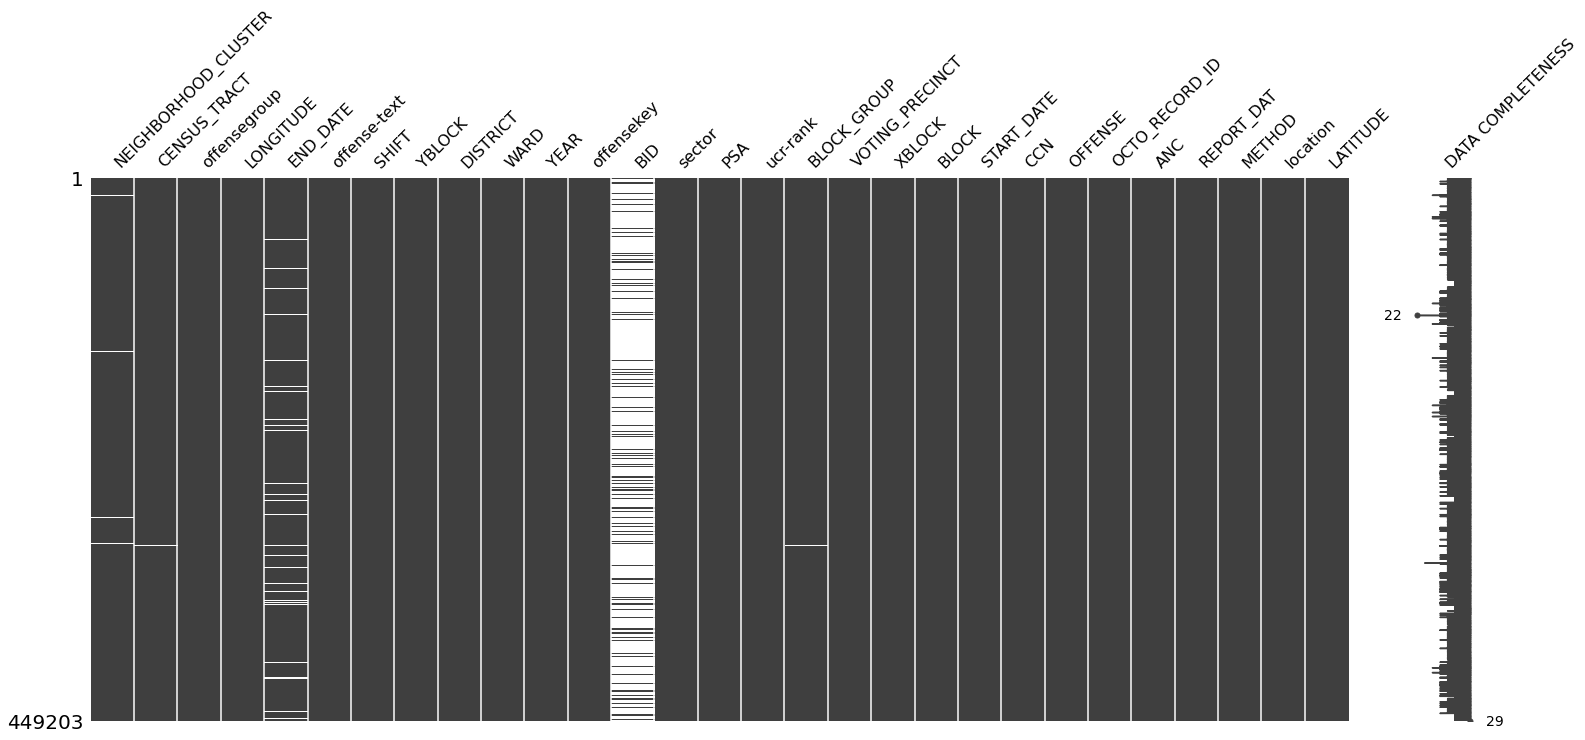

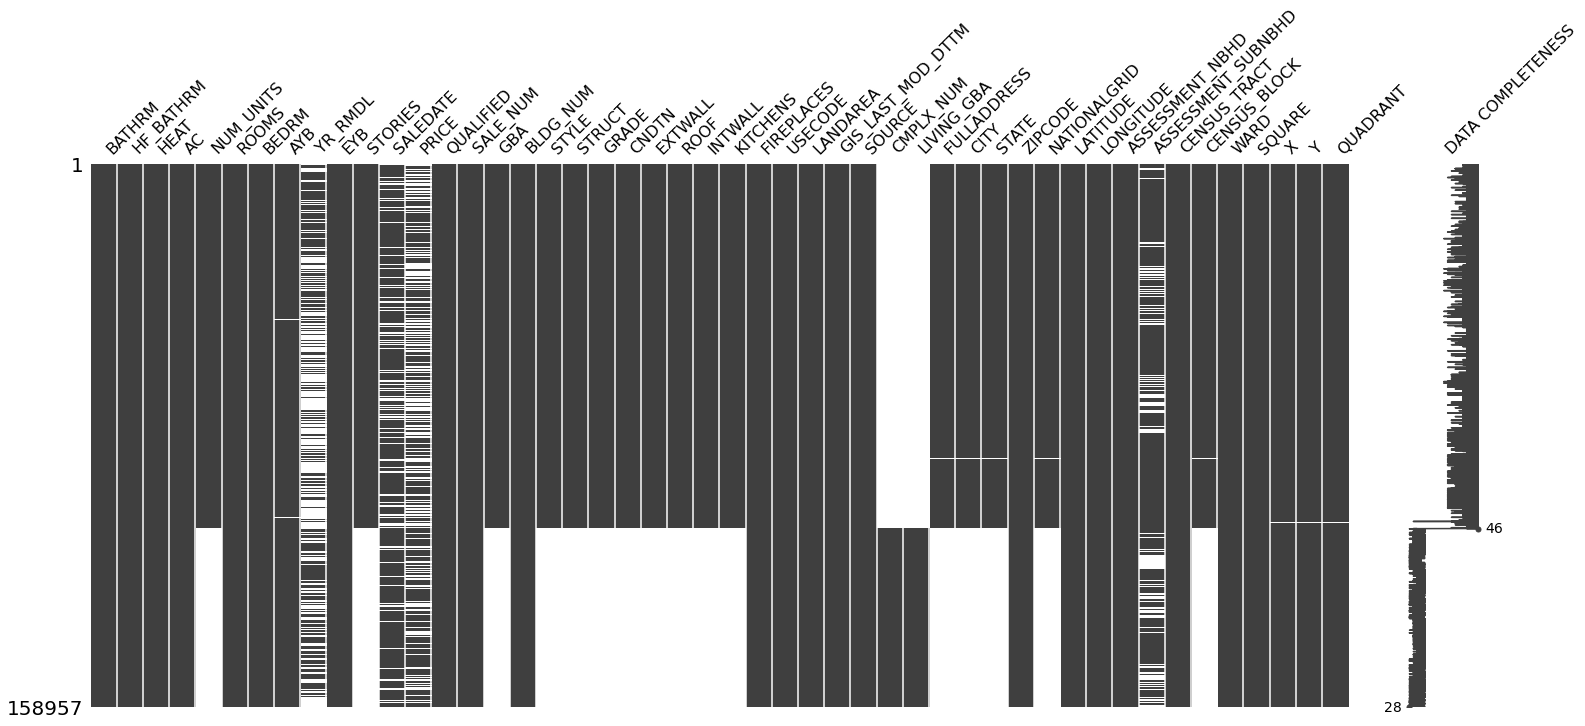

In [12]:
#查看样本数据缺失值情况
msno.matrix(crime, labels=True)
msno.matrix(housing, labels=True)

### 2.1.2 缺失值处理

经过初步的缺失值检测可以得出如下结论：

crime数据集里的BID字段数据缺失值较多，该特征已经不太具备说明度，可以删去，剩下的其他缺失值占总体比例较小，可以直接删去。

housing数据集中有很多列缺失值数据超过一半，对于缺失值超过一半的数据，可以选择删除字段，而对于缺失值没超过一半的数据，视情况处理。

- 显示需要处理的值，缺失值在80%以上的字段进行如下处理：
    - YR_RMDL：更新时间，补充为当前年份
    - ROOM数量类字段：ROOMS是100%，其他的可以不用太关心
    - CENSUS_BLOCK，STORIES，EXTWALL，CONDITION，LIVING_GBA：crime查找最近距离的xy点，使用其block标签标记
    - PRICE：完成以上操作后dropna
    - 其他：丢弃整个字段

In [147]:
del crime['BID']
crime.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

<AxesSubplot:>

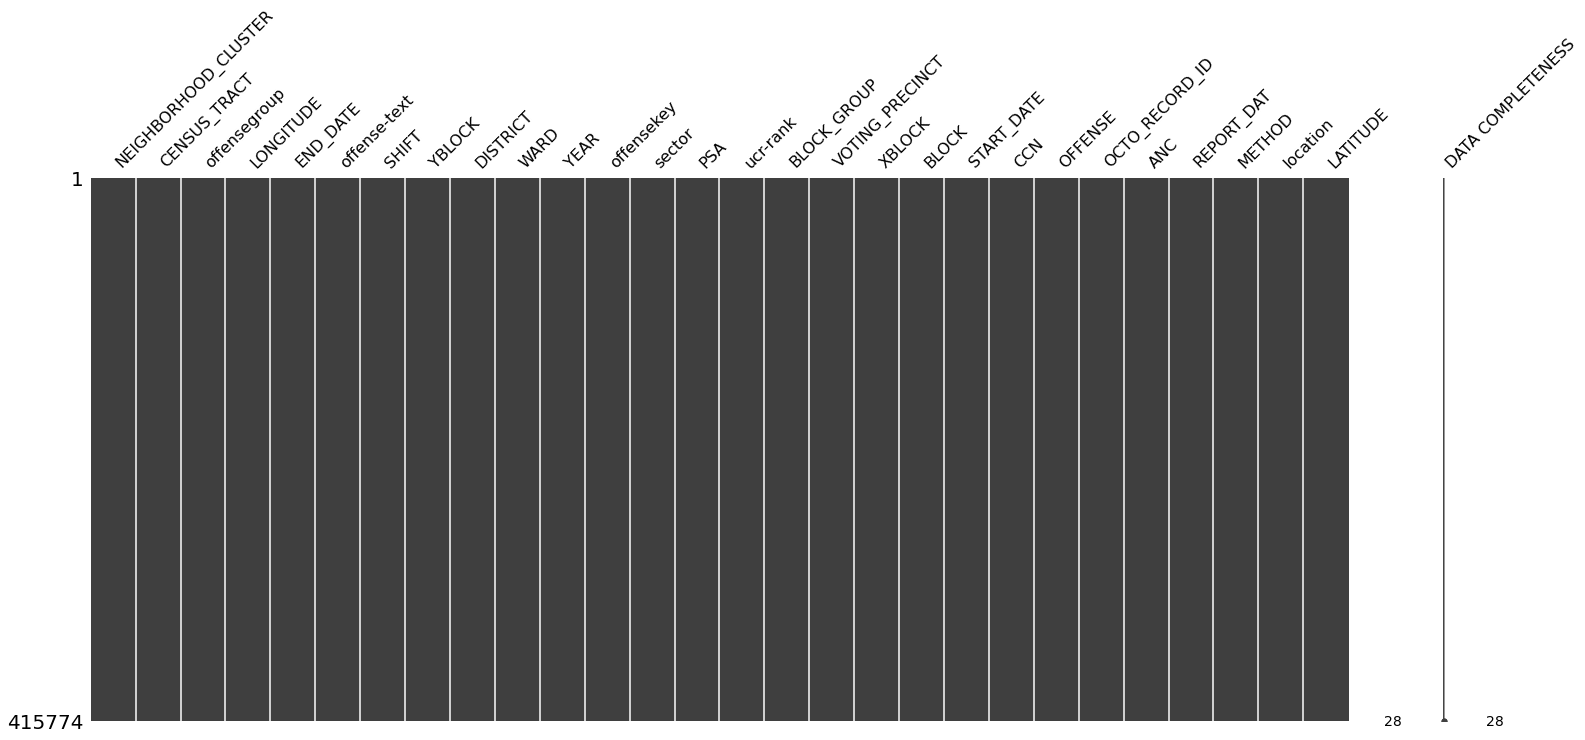

In [14]:
msno.matrix(crime, labels=True)

至此，crime数据集缺失值处理完毕。

### 2.1.3 crime数据集数据转换--非数值型转换为数值型

In [15]:
crime.select_dtypes(exclude = ['int64', 'float64'])

NEIGHBORHOOD_CLUSTER offensegroup                 END_DATE  \
0                cluster 21     property  2017-04-29T08:00:23.000   
1                cluster 16     property  2017-04-29T08:30:37.000   
2                 cluster 8     property  2017-04-29T11:10:57.000   
3                cluster 31     property  2017-04-28T09:30:33.000   
4                cluster 39     property  2017-04-29T13:42:11.000   
...                     ...          ...                      ...   
449198           cluster 22     property  2021-03-17T20:20:07.000   
449199            cluster 6     property  2021-03-17T17:20:33.000   
449200           cluster 23     property  2021-03-17T23:09:20.000   
449201           cluster 23     property  2021-03-17T22:40:24.000   
449202            cluster 3     property  2021-03-25T13:00:28.000   

               offense-text     SHIFT                    offensekey sector  \
0              theft f/auto       day         property|theft f/auto    5D1   
1              theft f/auto       day         property|theft f/auto    4D1   
2               theft/other       day          property|theft/other    1D1   
3               theft/other       day          property|theft/other    6D1   
4               theft/other       day          property|theft/other    7D3   
...                     ...       ...                           ...    ...   
449198          theft/other   evening          property|theft/other    5D2   
449199  motor vehicle theft   evening  property|motor vehicle theft    2D3   
449200          theft/other  midnight          property|theft/other    5D3   
449201  motor vehicle theft  midnight  property|motor vehicle theft    5D3   
449202         theft f/auto       day         property|theft f/auto    3D2   

       BLOCK_GROUP VOTING_PRECINCT  \
0         008702 2     precinct 75   
1         001600 2     precinct 62   
2         004702 1     precinct 18   
3         007808 3     precinct 96   
4         010900 2    precinct 125   
...            ...             ...   
449198    011100 3     precinct 72   
449199    005201 2     precinct 16   
449200    008802 2     precinct 77   
449201    008802 3     precinct 77   
449202    003400 1     precinct 20   

                                               BLOCK               START_DATE  \
0                     150 - 299 block of q street ne  2017-04-29T01:30:14.000   
1            7600  - 7699 block of georgia avenue nw  2017-04-29T02:30:10.000   
2                     600 - 699 block of k street nw  2017-04-29T10:43:33.000   
3               5715 5739  block of blaine street ne  2017-04-28T09:15:27.000   
4          4610 - 4659 block of south capitol street  2017-04-29T13:03:40.000   
...                                              ...                      ...   
449198         1815 - 1999 block of bryant street ne  2021-03-17T20:15:08.000   
449199              1500 - 1599 block of p street nw  2021-03-16T21:00:41.000   
449200        900 - 999 block of bladensburg road ne  2021-03-17T22:21:45.000   
449201  1300 - 1399 block of west virginia avenue ne  2021-03-17T22:38:11.000   
449202           300 - 399 block of oakdale place nw  2021-03-18T18:00:05.000   

                    OFFENSE OCTO_RECORD_ID ANC                REPORT_DAT  \
0              theft f/auto    17070672-01  5E  2017-04-29T13:49:31.000Z   
1              theft f/auto    17070675-01  4A  2017-04-29T14:38:59.000Z   
2               theft/other    17070714-01  6E  2017-04-29T15:19:02.000Z   
3               theft/other    17070736-01  7C  2017-04-29T16:11:44.000Z   
4               theft/other    17070780-01  8D  2017-04-29T18:17:15.000Z   
...                     ...            ...  ..                       ...   
449198          theft/other    21034375-01  5C   2021-03-17T21:07:30.000   
449199  motor vehicle theft    21034386-01  2B   2021-03-17T21:38:51.000   
449200          theft/other    21034407-01  5D   2021-03-18T01:12:46.000   
449201  motor vehicle theft    21034425-01  5D   20

In [16]:
crime.select_dtypes(exclude = ['int64', 'float64']).describe()

NEIGHBORHOOD_CLUSTER offensegroup                 END_DATE  \
count                415774       415774                   415774   
unique                   45            2                   359332   
top               cluster 2     property  2009-01-01T00:00:00.000   
freq                  33663       349059                       39   

       offense-text    SHIFT            offensekey  sector BLOCK_GROUP  \
count        415774   415774                415774  415774      415774   
unique            9        3                     9      21         450   
top     theft/other  evening  property|theft/other     2D3    005800 1   
freq         163292   179715                163292   39147       11129   

       VOTING_PRECINCT                                BLOCK  \
count           415774                               415774   
unique             144                                16907   
top       precinct 129  3100 - 3299 block of 14th street nw   
freq             18342                                 2850   

                     START_DATE      OFFENSE OCTO_RECORD_ID     ANC  \
count                    415774       415774         415774  415774   
unique                   344871            9         415773      40   
top     2015-08-23T20:00:00.000  theft/other    19073083-01      1B   
freq                         19       163292              2   24432   

                      REPORT_DAT  METHOD  \
count                     415774  415774   
unique                    388903       3   
top     2013-09-16T04:00:00.000Z  others   
freq                          12  380615   

                                     location  
count                                  415774  
unique                                  22286  
top     38.929520805242319,-77.03273284903338  
freq                                     2715

可以看出对于非数值型特征，需要采取不同的方式进行数值化转换，例如：

“NEIGHBORHOOD_CLUSTER”--映射有序特征

“offensegroup”--独热码

“END_DATE”--日期去掉年（已经有），转化成月日小时

“offense-text”--稀疏矩阵

“SHIFT”--独热码

“offensekey”--重复，丢弃

“sector”--去掉D转化成数字

“BLOCK_GROUP”--提取数字字符转化为数字

“VOTING_PRECINCT”--去除precinct转化为数字

“BLOCK”--

“START_DATE”--日期去掉年（已经有），转化成年月日小时

"OFFENSE"--与offensegroup重复，丢弃

“OCTO_RECORD_ID”--去掉-转化为数字

“ANC”--将字母转成对应的数字，例如5E-55

"REPORT_DAT"--犯罪时间的上报时间具有较强的主观因素，不太具备参考性

"METHOD"--独热码

“location”--经纬度信息

In [148]:
# crime数据集中非数值型特征初步转换
crime['NEIGHBORHOOD_CLUSTER'] = crime['NEIGHBORHOOD_CLUSTER'].str.extract('([0-9]+)').astype('int8')
crime['NEIGHBORHOOD_CLUSTER'].dtype

offensegroup_mapping = {'property': 1, "violent": 0}
crime['offensegroup'] = (crime['offensegroup'].map(offensegroup_mapping)).astype('int8')
crime['offensegroup'].unique()

crime['END_DATE'] = pd.to_datetime(crime['END_DATE'],infer_datetime_format=True)
crime['START_DATE'] = pd.to_datetime(crime['START_DATE'],infer_datetime_format=True)
crime['end_month'] = crime['END_DATE'].dt.month
crime['end_day'] = crime['END_DATE'].dt.day
crime['end_hour'] = crime['END_DATE'].dt.hour
crime['start_month'] = crime['START_DATE'].dt.month
crime['start_day'] = crime['START_DATE'].dt.day
crime['start_hour'] = crime['START_DATE'].dt.hour
crime['YEAR'] = crime['START_DATE'].dt.year
days = (pd.to_datetime(crime['END_DATE'],infer_datetime_format=True) - pd.to_datetime(crime['START_DATE'],infer_datetime_format=True)).dt.days * 24 * 60
seconds = (pd.to_datetime(crime['END_DATE'],infer_datetime_format=True) - pd.to_datetime(crime['START_DATE'],infer_datetime_format=True)).dt.seconds / 60
crime['duration'] = days + seconds

start = crime['START_DATE']
del crime['END_DATE']
del crime['START_DATE']

del crime['OFFENSE']
offense = pd.get_dummies(crime['offense-text'], prefix='offense', sparse=True)
crime = pd.concat([crime, offense], axis=1)
del crime['offense-text']

crime = pd.concat([crime, pd.get_dummies(crime['SHIFT'])], axis=1)
del crime['SHIFT']

crime['sector'] = crime['sector'].str.replace(r'[A-Z]', '').astype('int8')

crime['BLOCK_GROUP'] = crime['BLOCK_GROUP'].str.replace(' ', '').astype('int64')

crime['VOTING_PRECINCT'] = crime['VOTING_PRECINCT'].str.extract('([0-9]+)').astype('int8')

crime['OCTO_RECORD_ID'] = crime['OCTO_RECORD_ID'].str.replace('-', '').astype('int64')

digimapping = {}
i = 0
for char in range(65, 91):
    digimapping[chr(char)] = i
    i = i + 1
crime['ANC'] = crime['ANC'].str.cat(crime['ANC'].str[-1:].map(digimapping).astype('str')).str.replace(r'[A-Z]', '').astype('int8')

crime = pd.concat([crime, pd.get_dummies(crime['METHOD'], prefix='method')], axis=1)
del crime['METHOD']

crime['latitude'] = crime['location'].str.extract(r'(\d+\.?\d*)').astype('float64')
crime['longitude'] = crime['location'].str.replace(r'\d+\.?\d*\,', '').astype('float64')
del crime['location']

del crime['offensekey']
del crime['BLOCK']
del crime['LONGITUDE']
del crime['LATITUDE']

## housing 数据集

### 2.1.1 缺失值、非数值映射、数据填充、离群值

In [9]:
df_temp = df
df_temp = df_temp.dropna(subset = ['PRICE'],axis=0)
# 删除丢弃的所有列
droplist = np.array(df_info[df_info['percentage']<80]['index']).tolist()
remainlist = ['PRICE','CENSUS_BLOCK','STORIES','EXTWALL','LIVING_GBA','YR_RMDL']
for remain in remainlist:
    droplist.remove(remain)
df_temp = df_temp.drop(droplist,axis = 1)

In [ ]:
# 进行非数值字段的映射
housing = df_temp
housing = housing.dropna(subset = ['SQUARE'], axis=0)
housing = housing[housing['SQUARE']!='PAR ']
housing['SQUARE'] = housing['SQUARE'].apply(int)
housing['SALEDATE'] = pd.to_datetime(housing['SALEDATE'],infer_datetime_format=True)
housing['GIS_LAST_MOD_DTTM'] = pd.to_datetime(housing['GIS_LAST_MOD_DTTM'],infer_datetime_format=True)
housing['SALEDATE_year'] = housing['SALEDATE'].dt.year
housing['SALEDATE_month'] = housing['SALEDATE'].dt.month
housing['SALEDATE_day'] = housing['SALEDATE'].dt.day
# housing['SALEDATE_hour'] = housing['SALEDATE'].dt.hour
housing['GIS_LAST_MOD_DTTM_year'] = housing['GIS_LAST_MOD_DTTM'].dt.year
housing['GIS_LAST_MOD_DTTM_month'] = housing['GIS_LAST_MOD_DTTM'].dt.month
housing['GIS_LAST_MOD_DTTM_day'] = housing['GIS_LAST_MOD_DTTM'].dt.day
housing['GIS_LAST_MOD_DTTM_hour'] = housing['GIS_LAST_MOD_DTTM'].dt.hour
housing = housing.drop(columns=['SALEDATE','GIS_LAST_MOD_DTTM'])
ref = housing

housing = df_temp
housing = housing.dropna(subset = ['SQUARE'], axis=0)
housing = housing[housing['SQUARE']!='PAR ']
housing['SQUARE'] = housing['SQUARE'].apply(int)
housing['SALEDATE'] = pd.to_datetime(housing['SALEDATE'],infer_datetime_format=True)
housing['GIS_LAST_MOD_DTTM'] = pd.to_datetime(housing['GIS_LAST_MOD_DTTM'],infer_datetime_format=True)
housing['SALEDATE_year'] = housing['SALEDATE'].dt.year
housing['SALEDATE_month'] = housing['SALEDATE'].dt.month
housing['SALEDATE_day'] = housing['SALEDATE'].dt.day
housing['GIS_LAST_MOD_DTTM_year'] = housing['GIS_LAST_MOD_DTTM'].dt.year
housing['GIS_LAST_MOD_DTTM_month'] = housing['GIS_LAST_MOD_DTTM'].dt.month
housing['GIS_LAST_MOD_DTTM_day'] = housing['GIS_LAST_MOD_DTTM'].dt.day
housing['GIS_LAST_MOD_DTTM_hour'] = housing['GIS_LAST_MOD_DTTM'].dt.hour
housing = housing.drop(columns=['SALEDATE','GIS_LAST_MOD_DTTM'])
# 非数值型字段（表示不同类别的）对应数值编码
cols = housing.select_dtypes(exclude = ['int64', 'float64']).columns
for c in cols:
    class_mapping = {label: idx for idx, label in enumerate(np.unique(ref[c].dropna()))}
    housing[c] = housing[c].map(class_mapping)
housing = housing.reset_index(drop = True)
housing['YR_RMDL'] = housing['YR_RMDL'].fillna(2021)

<AxesSubplot:>

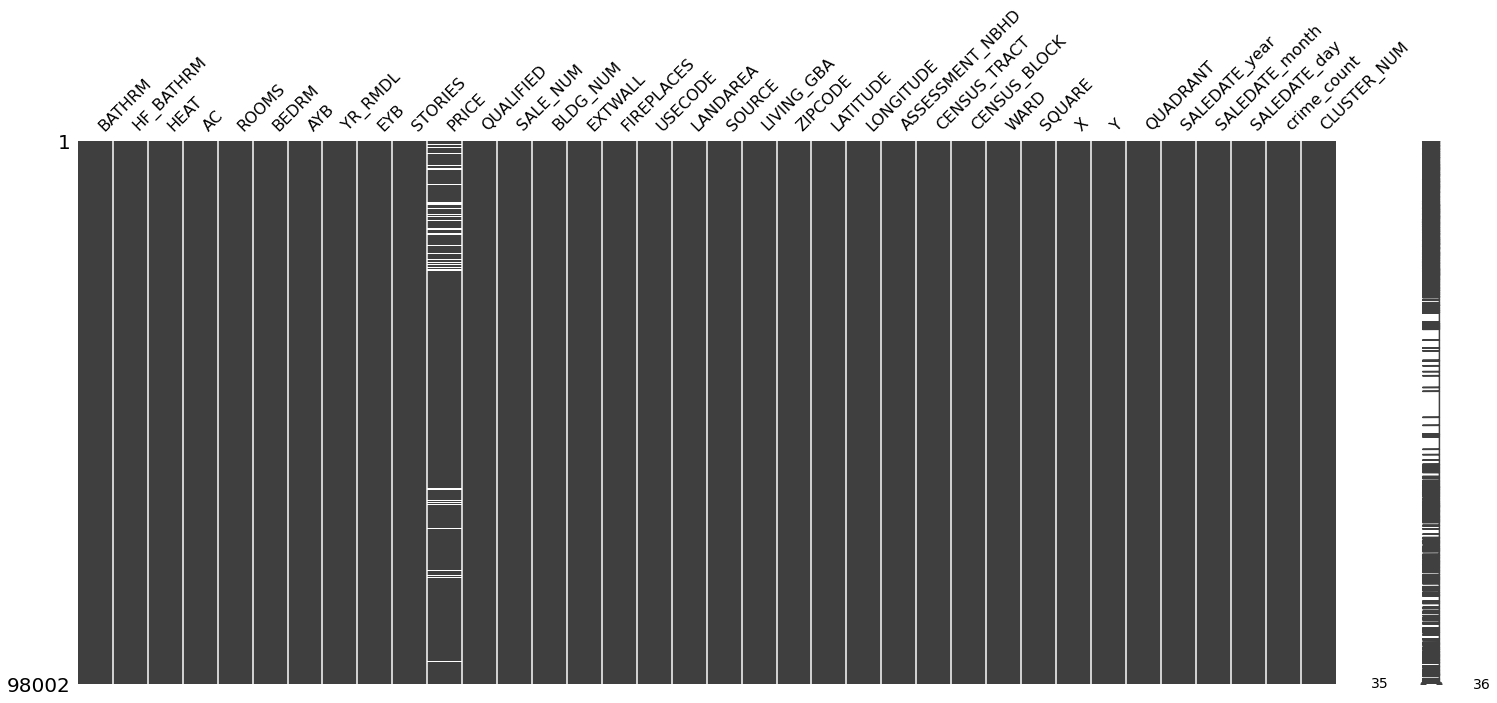

In [29]:
msno.matrix(housing)

In [ ]:
# KNN实现数据填充
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
knnimputelist = ['STORIES','CENSUS_BLOCK','EXTWALL','LIVING_GBA']
housing = housing
for c in tqdm(knnimputelist):
    temp = housing[['X','Y',c]]
#   print(temp[temp.isnull().T.any()])
    temp = imputer.fit_transform(temp)
    housing[c] = temp[:,2]
#   print(temp[temp[c].isnull()])
# msno.matrix(housing)
housing = housing.dropna(axis = 0)
# msno.matrix(housing)
housing.to_csv("./housing.csv",index = False)
housing = pd.read_csv("./housing.csv",index_col = False)
msno.matrix(housing)

- 按照一定范围内的犯罪数量作为犯罪字段

In [ ]:
crime = pd.read_csv("./DC_Crime.csv", index_col=None)
housing = pd.read_csv("./housing.csv", index_col=None)
threshold = 0.000001
temp = crime[['LONGITUDE','LATITUDE']]
def crime_count(longitude,latitude):
    temp['lo'] = longitude
    temp['la'] = latitude
    temp['distance'] = (temp['LONGITUDE']-temp['lo'])**2+(temp['LATITUDE']-temp['la'])**2
    return (temp[temp['distance']<threshold].count()[0])

housing['crime_count'] = housing.apply(lambda x:crime_count(x['LONGITUDE'],x['LATITUDE']),axis=1)
housing.to_csv("./housing_crime.csv",index = None)

- 生成CLUSTER列

In [ ]:
housing = pd.read_csv("./housing_crime.csv", index_col=None)
def findCluster(x,y):
    temp = geo
    temp['x'] = x
    temp['y'] = y
    temp['label'] = temp['geometry'].contains(geometry.Point([x,y]))
    result = np.array(temp[temp['label']==True]['NAME'])[0]
    return result
housing['CLUSTER'] = housing.apply(lambda x:findCluster(x['X'],x['Y']),axis = 1)
housing['CLUSTER_NUM'] = housing['CLUSTER'].str.extract('([0-9]+)').astype('int8')
housing.to_csv("./housing_crime_cluster.csv",index = None)

- load处理好的数据，并且去除无用字段:
    - Cluster已经有cluster_num代替
    - GIS相关时间 全部一样，不具有参考价值

In [13]:
housing = pd.read_csv("./data/housing_crime_cluster.csv")
housing = housing.drop(columns = ['CLUSTER','GIS_LAST_MOD_DTTM_year','GIS_LAST_MOD_DTTM_month','GIS_LAST_MOD_DTTM_day','GIS_LAST_MOD_DTTM_hour'],axis = 1)
housing.to_csv("./data/housing_final.csv",index = None)

In [226]:
housing = pd.read_csv("./data/housing_final.csv",index_col = None)

- 异常值剔除，采用箱线图剔除方法

{'whiskers': [<matplotlib.lines.Line2D at 0x27840210a90>,
 'caps': [<matplotlib.lines.Line2D at 0x27840ac4048>,
 'boxes': [<matplotlib.lines.Line2D at 0x27840210748>],
 'medians': [<matplotlib.lines.Line2D at 0x2783fc3d550>],
 'fliers': [<matplotlib.lines.Line2D at 0x2783fc3d828>],
 'means': []}

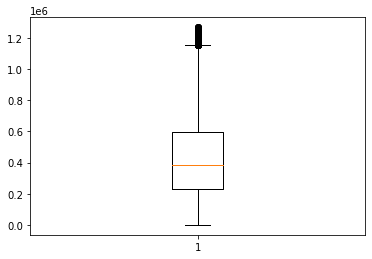

In [172]:
def box_plot_outlier(data):
#     deg = pd.Series(data)
    deg = data
    deg = data
    mean = np.mean(deg)
    var = np.var(deg)
    percentile = np.percentile(deg, (25, 50, 75), interpolation='midpoint')
    #以下为箱线图的五个特征值
    Q1 = percentile[0]#上四分位数
    Q3 = percentile[2]#下四分位数
    IQR = Q3 - Q1#四分位距
    ulim = Q3 + 1.5*IQR#上限 非异常范围内的最大值
    llim = Q1 - 1.5*IQR#下限 非异常范围内的最小值
    new_deg = []
    for i in range(len(deg)):
        if(llim<deg[i] and deg[i]<ulim):
            new_deg.append(deg[i])
        else:
            new_deg.append(np.nan)
    return pd.DataFrame(new_deg)
inHousing = housing
inHousing['PRICE'] = box_plot_outlier(inHousing['PRICE'])
inHousing = inHousing.dropna()
plt.boxplot(inHousing['PRICE'])

### 2.1.2 housing数据集归一化处理

In [173]:
def autoNorm(data): #传入一个矩阵
    mins = data.min(0) #返回data矩阵中每一列中最小的元素，返回一个列表
    maxs = data.max(0) #返回data矩阵中每一列中最大的元素，返回一个列表
    ranges = maxs - mins #最大值列表 - 最小值列表 = 差值列表
    normData = np.zeros(np.shape(data)) #生成一个与 data矩阵同规格的normData全0矩阵，用于装归一化后的数据
    row = data.shape[0] #返回 data矩阵的行数
    normData = data - np.tile(mins,(row,1)) #data矩阵每一列数据都减去每一列的最小值
    normData = normData / np.tile(ranges,(row,1)) #data矩阵每一列数据都除去每一列的差值(差值 = 某列的最大值- 某列最小值)
    return normData,mins,ranges
normHousing,mins,ranges = autoNorm(inHousing)

## 2.2 数据探索

这部分将探索数据之间的相互关系

## Crime数据集

首先我们可以利用seaborn画出crime数据集两两变量之间的关系。

两两特征之间，有些散乱分布，则视为它们基本无关，还有一些基本呈正比例线性关系，则两个特征很可能存在某种因果关系或者重复性。

接下来我们对关系较为明显的特征做更进一步分析。

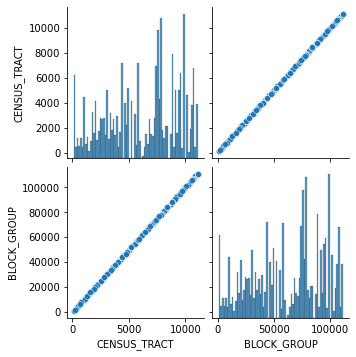

In [18]:
sns.pairplot(crime[['CENSUS_TRACT',  'BLOCK_GROUP']])

从图中可以看出：

这两个变量之间基本呈一次正比例线性关系，数据存在重复性，我们这里可以将“CENSUS_TRACT”特征删去。

In [121]:
del crime['CENSUS_TRACT']

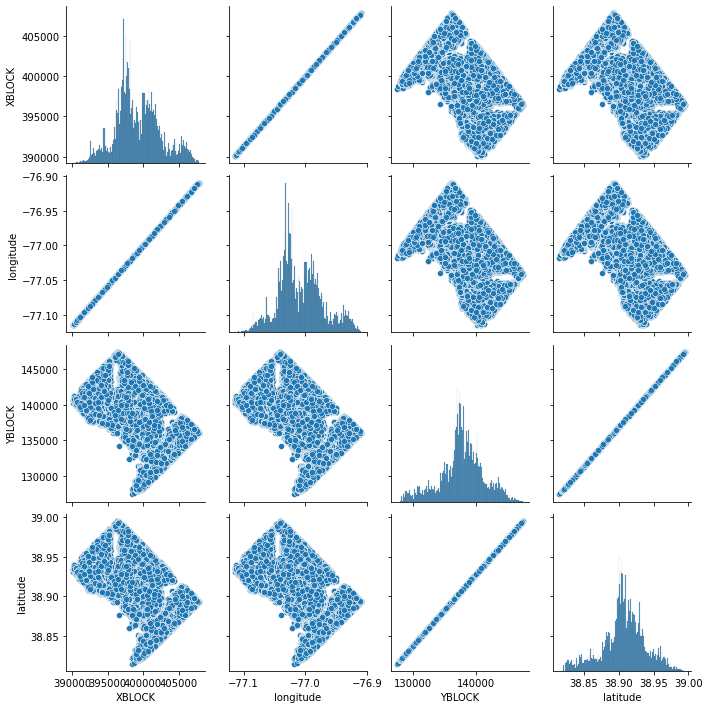

In [20]:
sns.pairplot(crime[['XBLOCK',  'longitude', 'YBLOCK', 'latitude']])

同理，我们发现['XBLOCK',  'longitude']和['YBLOCK', 'latitude']均为重复数据组，这里删去特征“XBLOCK”和“YBLOCK”

In [122]:
del crime['XBLOCK']
del crime['YBLOCK']

In [22]:
pd.DataFrame(crime['BLOCK_GROUP'].unique()).count()

0    450
dtype: int64

In [23]:
crime['BLOCK_GROUP']

0          87022
1          16002
2          47021
3          78083
4         109002
           ...  
449198    111003
449199     52012
449200     88022
449201     88023
449202     34001
Name: BLOCK_GROUP, Length: 415774, dtype: int64

## 2.2.1 数据分布探索

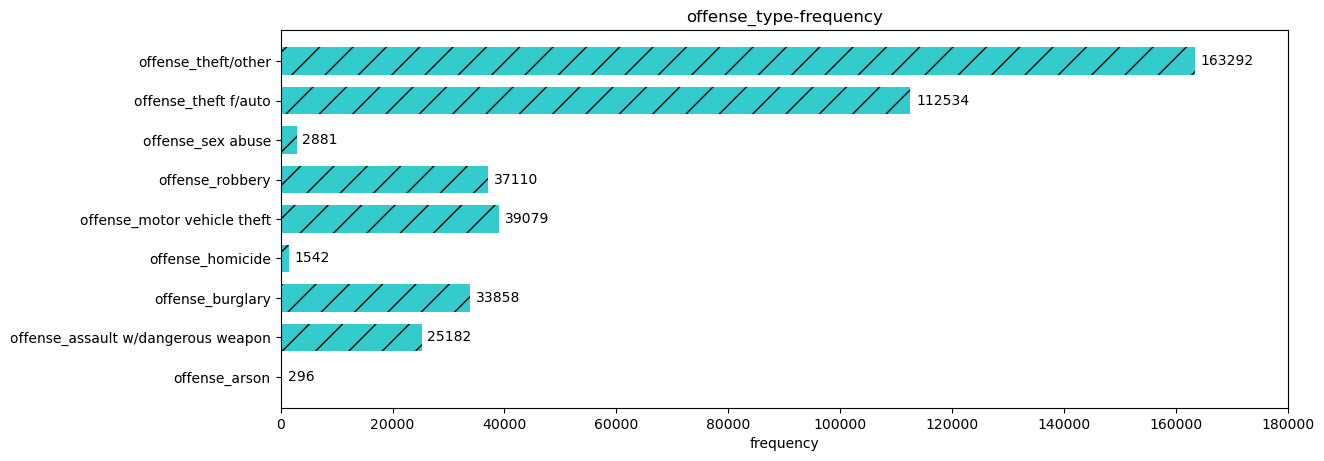

In [24]:
data = []
for item in offense:
    data.append(offense[item].value_counts()[1])
plt.figure(figsize=(13,5), dpi=100)
plt.barh(range(9), data, height=0.7, color='c', alpha=0.8, hatch='/')      # 从下往上画
plt.yticks(range(9), offense.columns)
plt.xlim(0,180000)
plt.xlabel("frequency")
plt.title("offense_type-frequency")
for x, y in enumerate(data):
    plt.text(y + 1000, x - 0.1, '%s' % y)
plt.show()

从上图可以看出：

* 其他类型犯罪发生次数最多，其实是机动车盗窃

* 抢劫、摩托车犯罪、入室盗窃和武器袭击发生次数较多

* 性虐待、自杀和纵火发生次数较少

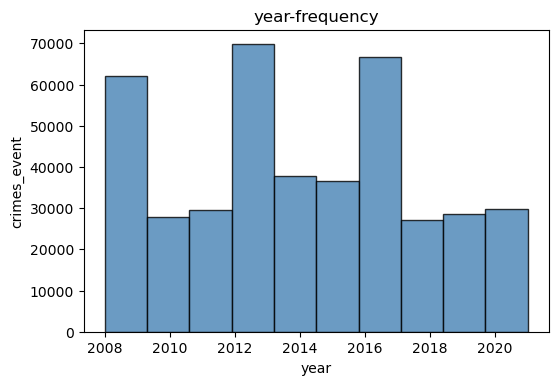

In [25]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(crime['YEAR'], density=False, facecolor="steelblue", edgecolor="black", alpha=0.8)
plt.xlabel("year")
plt.ylabel("crimes_event")
plt.title("year-frequency")
plt.show()

由上图可以总结出：

* 2008\~2009、2012\~2013和2016\~2017这三年为犯罪高发期。

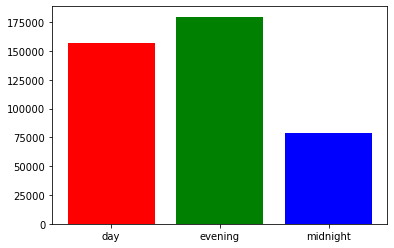

In [149]:
data = pd.Series(index=['day', 'evening', 'midnight'])
for index in data.index:
    data[index] = crime[crime[index] == 1].shape[0]
plt.bar(data.index, data, color=['r', 'g', 'b'])
plt.show()

由上图可以总结出：

* 夜晚是一天中犯罪时间发生最频繁的时期。
* 午夜犯罪发生频率最低。

## Housing数据集

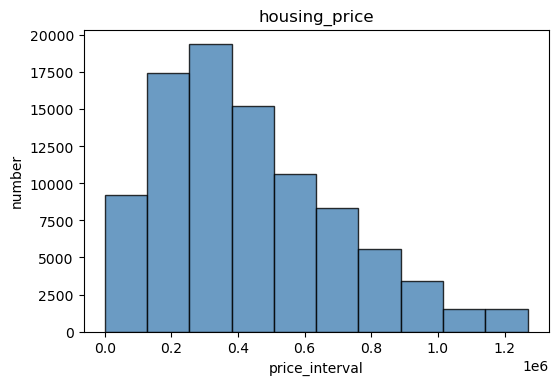

In [229]:
housing = inHousing
plt.figure(figsize=(6,4), dpi=100)
plt.hist(housing['PRICE'], density=False, facecolor="steelblue", edgecolor="black", alpha=0.8)
plt.xlabel("price_interval")
plt.ylabel("number")
plt.title("housing_price")
plt.show()

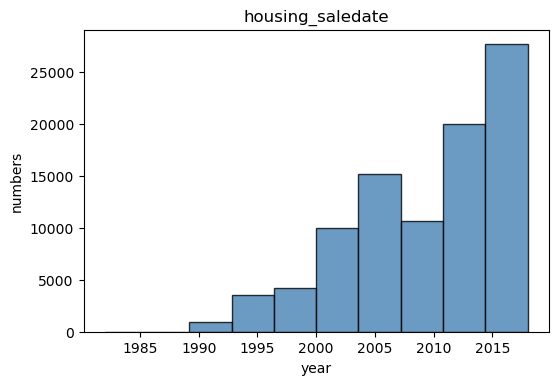

In [230]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(housing['SALEDATE_year'], density=False, facecolor="steelblue", edgecolor="black", alpha=0.8)
plt.xlabel("year")
plt.ylabel("numbers")
plt.title("housing_saledate")
plt.show()

housing数据集数据分布探索总结：
- 房价基本呈现右偏分布，房价较低的房屋数量较多

- 可以看到交易数量的整体趋势是逐年升高

## 2.2.2 数据相关性探索

### crime数据集

<AxesSubplot:>

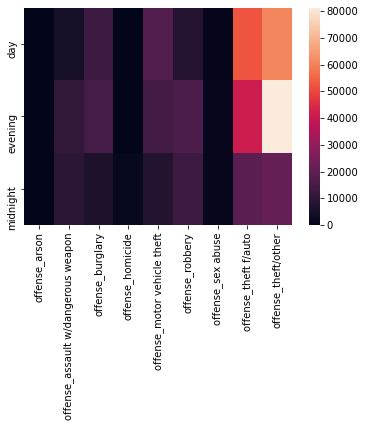

In [27]:
heat_map = pd.DataFrame(index=['day', 'evening', 'midnight'], columns=crime.columns[21:30])
for index in heat_map.index:
    for col in crime.columns[21:30]:
        heat_map[col][index] = crime[(crime[index] == 1) & (crime[col] == 1)].shape[0]
heat_map = heat_map.astype('int64')
sns.heatmap(heat_map)

从上图可以看出：

* 其他类型犯罪和机动车犯罪在一天的三个时间段均为高发类型。
* 夜晚为其他类型犯罪的最高发时期。
* 白天为机动车犯罪的最高发时期。
* 抢劫在夜晚有较高的发生频率。
* 摩托车盗窃主要发生在白天。
* 入室盗窃主要发生在夜晚。

In [28]:
heat_map = pd.DataFrame()
day = ['day', 'evening', 'midnight']
for time in day:
    heat_map[time] = crime[crime[time] == 1]['YEAR']
heat_map['evening'] = crime[crime['evening'] == 1]['YEAR']
heat_map
# heat_map = heat_map.astype('int64')
# sns.set(style="whitegrid")
# sns.boxplot(x="tip", y="day", data=heat_map, whis=np.inf)
# sns.stripplot(x="tip", y="day", data=heat_map,
#               jitter=True, color=".3")
# plt.show()

day  evening  midnight
0       2017      NaN       NaN
1       2017      NaN       NaN
2       2017      NaN       NaN
3       2017      NaN       NaN
4       2017      NaN       NaN
...      ...      ...       ...
449175  2021      NaN       NaN
449179  2021      NaN       NaN
449180  2021      NaN       NaN
449181  2021      NaN       NaN
449202  2021      NaN       NaN

[157115 rows x 3 columns]

<AxesSubplot:>

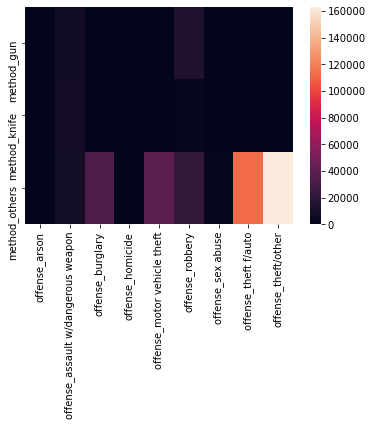

In [29]:
heat_map = pd.DataFrame(index=crime.columns[33:36], columns=crime.columns[21:30])
for index in heat_map.index:
    for col in heat_map.columns:
        heat_map[col][index] = crime[(crime[index] == 1) & (crime[col] == 1)].shape[0]
heat_map = heat_map.astype('int64')
sns.heatmap(heat_map)

由上图可以看出：

* 使用枪支和刀具的只占总体犯罪的很小一部分，但枪支犯罪要比刀具犯罪更容易发生。
* 其他类型犯罪中，机动车犯罪、抢劫、摩托车犯罪和其他类型犯罪占比较高。

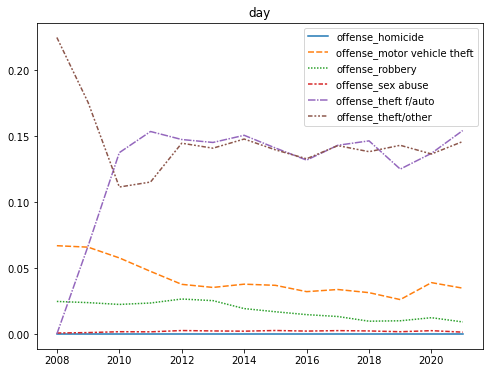

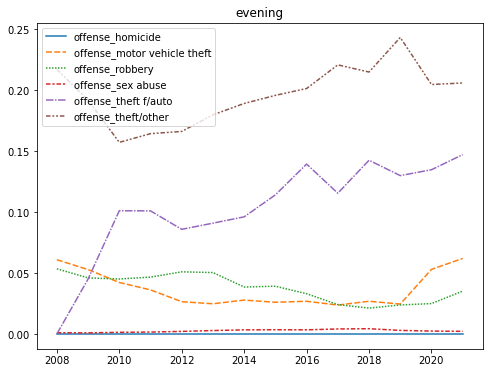

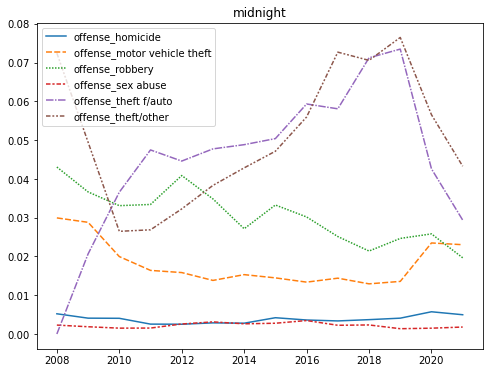

In [30]:
year = crime['YEAR'].unique()
data = pd.DataFrame(index = year, columns = crime.columns[24:30])
shift = ['day', 'evening', 'midnight']
for time in shift:
    for index in year:
        for col in data.columns:
            num = crime[crime['YEAR'] == index].shape[0]
            data[col][index] = crime[(crime[time] == 1) & (crime[col] == 1) & (crime['YEAR'] == index)].shape[0] / num
    data = data.astype('float64')
    plt.figure(figsize=(8, 6))
    plt.title(time)
    sns.lineplot(data=data)
    plt.show()

上述三张图分别选取了六种犯罪类型在一天中三个不同时间段的__频率占比__，依据犯罪发生时间的变化。

从图中可以看出：

* 性虐待和杀人犯罪发生频率一直较低，__特别的：杀人犯罪只在午夜发生，在其他两个时间段发生频率均为0。__
* 其他犯罪类型波动较大。
* __其中抢劫和摩托车盗窃案整体处于下降趋势。__
* __机动车盗窃/犯罪案件逐年上升，可能与机动车价格下降，人均拥有机动车数日渐上升有关。__

In [210]:
test = crime[['YEAR','start_month','start_day','NEIGHBORHOOD_CLUSTER']]
test['year'] = test['YEAR'].astype('int64').apply(str)
test['month'] = test['start_month'].astype('int64').apply(str)
test['day'] = test['start_day'].astype('int64').apply(str)
test['date'] = test['year']+"-"+test['month']+'-'+test['day']
test['date'] = pd.to_datetime(test['date'],format = '%Y-%m-%d')
test.index = test['date']
test = test[['NEIGHBORHOOD_CLUSTER']]
test = test[test.index.year>=2008]
test = test.resample('M').count()
test = test.fillna(method = 'ffill')
crime_pred = test.copy()

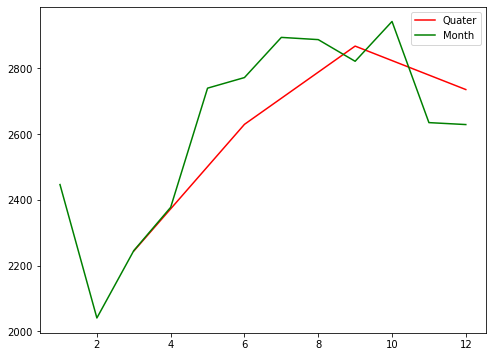

In [211]:
plt.figure(figsize=(8, 6))
q = crime_pred.resample('Q').sum()
# 这里/3操作是为了保持两条曲线维度一致
plt.plot(q.groupby(q.index.month).mean() / 3, color='r', label='Quater')
q = crime_pred.resample('M').sum()
plt.plot(q.groupby(q.index.month).mean(), color='g', label='Month')
plt.legend(loc='best')
plt.show()

从季度聚合可以看出：

* __春季犯罪数量最少，秋季最多，一年中整体呈上升趋势__

从月份聚合可以看出：

* __与季度聚合趋势大致相同__

* __一月份犯罪数量异常偏高，可能是因为气候仍然较冷__

### housing数据集

绘制相关性矩阵热力图

<AxesSubplot:>

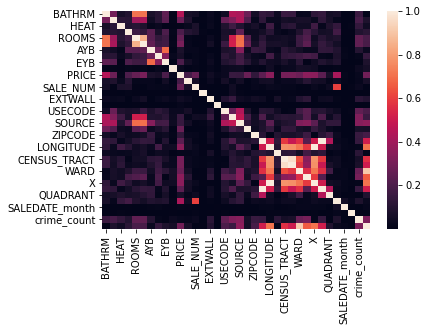

In [30]:
housing_cor = housing.corr().abs()
sns.heatmap(housing_cor)

In [31]:
high_corr_var=np.where(housing_cor>0.8)
high_corr_var=[(housing_cor.columns[x],housing_cor.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [32]:
high_corr_var

[('ROOMS', 'BEDRM'),
 ('LATITUDE', 'Y'),
 ('LONGITUDE', 'X'),
 ('CENSUS_TRACT', 'CENSUS_BLOCK'),
 ('WARD', 'CLUSTER_NUM')]

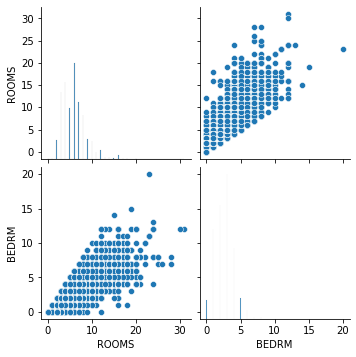

In [33]:
sns.pairplot(housing[['ROOMS',  'BEDRM']])

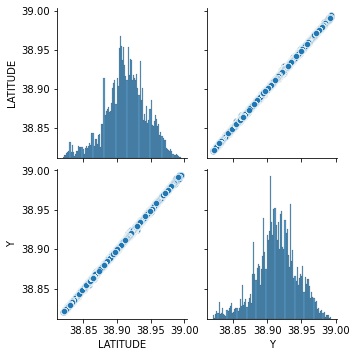

In [34]:
sns.pairplot(housing[['LATITUDE',  'Y']])

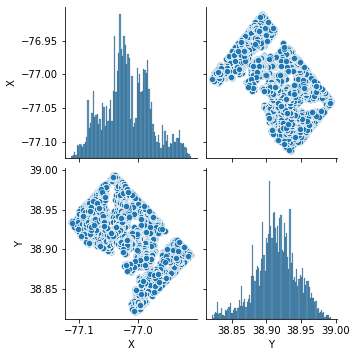

In [35]:
sns.pairplot(housing[['X',  'Y']])

In [36]:
drop_var = [(i[0]) for i in high_corr_var]
housing_new = housing.drop(columns=drop_var)

<AxesSubplot:>

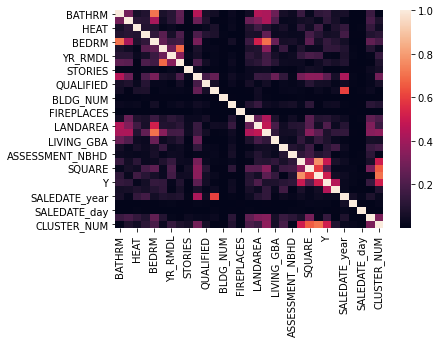

In [37]:
housing_new_cor = housing_new.corr().abs()
sns.heatmap(housing_new_cor)

## 2.3 犯罪事件与时空信息探索

In [154]:
dc.head(10)

OBJECTID                  WEB_URL        NAME  \
0         1  http://planning.dc.gov/  Cluster 39   
1         2  http://planning.dc.gov/  Cluster 38   
2         3  http://planning.dc.gov/  Cluster 36   
3         4  http://planning.dc.gov/  Cluster 27   
4         5  http://planning.dc.gov/  Cluster 32   
5         6  http://planning.dc.gov/   Cluster 8   
6         7  http://planning.dc.gov/   Cluster 5   
7         8  http://planning.dc.gov/  Cluster 30   
8         9  http://planning.dc.gov/  Cluster 31   
9        10  http://planning.dc.gov/   Cluster 7   

                                           NBH_NAMES  Shape_Length  \
0   Congress Heights, Bellevue, Washington Highlands  10711.668010   
1                           Douglas, Shipley Terrace   8229.486324   
2  Woodland/Fort Stanton, Garfield Heights, Knox ...   4746.344457   
3                          Near Southeast, Navy Yard   7286.968902   
4      River Terrace, Benning, Greenway, Dupont Park  11251.012821   
5  Downtown, Chinatown, Penn Quarters, Mount Vern...   7343.048621   
6                        West End, Foggy Bottom, GWU   5884.746359   
7               Mayfair, Hillbrook, Mahaning Heights   7599.065608   
8  Deanwood, Burrville, Grant Park, Lincoln Heigh...   8570.352866   
9                                 Shaw, Logan Circle   5004.594673   

     Shape_Area      TYPE                                           geometry  
0  4.886463e+06  Original  POLYGON ((-76.99402 38.84520, -76.99471 38.845...  
1  2.367958e+06  Original  POLYGON ((-76.97472 38.85287, -76.97499 38.853...  
2  1.119573e+06  Original  POLYGON ((-76.96877 38.86067, -76.96907 38.860...  
3  1.619167e+06  Original  POLYGON ((-76.98726 38.87712, -76.98860 38.877...  
4  4.286254e+06  Original  POLYGON ((-76.93760 38.88996, -76.93783 38.890...  
5  2.937442e+06  Original  POLYGON ((-77.00906 38.90566, -77.00904 38.907...  
6  1.358616e+06  Original  POLYGON ((-77.05011 38.90899, -77.05010 38.909...  
7  2.524927e+06  Original  POLYGON ((-76.94755 38.90597, -76.94925 38.908...  
8  3.330854e+06  Original  POLYGON ((-76.91322 38.88976, -76.91234 38.890...  
9  1.463803e+06  Original  POLYGON ((-77.03195 38.91410, -77.03333 38.914...

In [155]:
dc[dc['NAME'].isnull()]

Empty GeoDataFrame
Columns: [OBJECTID, WEB_URL, NAME, NBH_NAMES, Shape_Length, Shape_Area, TYPE, geometry]
Index: []

由此可以得知cluster没有缺失值。

In [156]:
dc['NAME'] = dc['NAME'].str.extract('([0-9]+)').astype('int8')
dc['NAME'].dtype

dtype('int8')

In [157]:
crime_grp = crime.groupby("NEIGHBORHOOD_CLUSTER")['NEIGHBORHOOD_CLUSTER', 'day'].sum().astype('int64')
crime_grp.index.name = 'index'
crime_grp.head()

NEIGHBORHOOD_CLUSTER    day
index                             
1                     10709   4189
2                     67326  12414
3                     53739   5790
4                     49104   4208
5                     34575   2654

In [158]:
# merge two dataset
dc = dc.merge(crime_grp, left_on='NAME', right_on='index', how='left')
dc = dc.drop('day', axis=1)
dc['NEIGHBORHOOD_CLUSTER'] = dc['NEIGHBORHOOD_CLUSTER'].fillna(0)
dc.head()

OBJECTID                  WEB_URL  NAME  \
0         1  http://planning.dc.gov/    39   
1         2  http://planning.dc.gov/    38   
2         3  http://planning.dc.gov/    36   
3         4  http://planning.dc.gov/    27   
4         5  http://planning.dc.gov/    32   

                                           NBH_NAMES  Shape_Length  \
0   Congress Heights, Bellevue, Washington Highlands  10711.668010   
1                           Douglas, Shipley Terrace   8229.486324   
2  Woodland/Fort Stanton, Garfield Heights, Knox ...   4746.344457   
3                          Near Southeast, Navy Yard   7286.968902   
4      River Terrace, Benning, Greenway, Dupont Park  11251.012821   

     Shape_Area      TYPE                                           geometry  \
0  4.886463e+06  Original  POLYGON ((-76.99402 38.84520, -76.99471 38.845...   
1  2.367958e+06  Original  POLYGON ((-76.97472 38.85287, -76.97499 38.853...   
2  1.119573e+06  Original  POLYGON ((-76.96877 38.86067, -76.96907 38.860...   
3  1.619167e+06  Original  POLYGON ((-76.98726 38.87712, -76.98860 38.877...   
4  4.286254e+06  Original  POLYGON ((-76.93760 38.88996, -76.93783 38.890...   

   NEIGHBORHOOD_CLUSTER  
0              686712.0  
1              276184.0  
2              150624.0  
3               76977.0  
4              321280.0

In [159]:
centroid=dc.geometry.centroid ## identifies the center point of all the neighborhood shapes 
m=folium.Map(location=[centroid.y.mean(), centroid.x.mean()], zoom_start=12) ## initiaes a map based on the centroid
m

这里导入了DC_Neighborhood_cluster地理信息数据集，利用folium包初始化地理信息图像。

In [160]:
variable = 'NEIGHBORHOOD_CLUSTER' #active restaurants in Washington, DC as of 9/2019
name = '# crime frequency'

print(name, "colorscale")
print("Min:",dc[variable].min())
print("Max:",dc[variable].max())
    
colorscale = branca.colormap.linear.YlOrRd_09.scale(dc[variable].min(), dc[variable].max()) 
colorscale

# crime frequency colorscale
Min: 0.0
Max: 686712.0


In [161]:
# create df with neighborhood name and variable of interest, sorted from largest to smallest
df = dc[['NAME', variable]].sort_values(by = variable, ascending = False) 
    
# reset index so that the largest value corresponds to row 0 and smallest to row 136
df.reset_index(inplace = True)
leg_brks = list(df[df.index.isin([0,4,9,19,29,49])][variable]) # identify the value of the var by index position
    
# make the smallest value of the scale be 0
leg_brks.append(0)
leg_brks.sort() # sort from smallest to largest
print("Quantiles:", leg_brks)

Quantiles: [0, 53739.0, 136360.0, 316428.0, 367218.0, 686712.0]


In [162]:
print(name, "colorscale")

colorscale = branca.colormap.linear.YlOrRd_09.scale(dc[variable].min(), dc[variable].max()) 
colorscale = colorscale.to_step(n = 6, quantiles = leg_brks) ## sets quantile breaks 
colorscale.caption = name ## adds name for legend
    
colorscale

# crime frequency colorscale


In [163]:
variable = 'NEIGHBORHOOD_CLUSTER' #active restaurants in Washington, DC as of 9/2019
name = '# crime frequency'


folium.GeoJson(dc, ## GeoPandas dataframe
               name="Washington DC",
                   
               ## controls the fill of the geo regions; applying colorscale based on variable
               style_function=lambda x: {"weight":1
                                         , 'color': '#545453'
                                         ## if variable is 0 map is a very light grey
                                         ## else colorscale applies based on variable
                                         , 'fillColor':'#9B9B9B' if x['properties'][variable] == 0 
                                         else colorscale(x['properties'][variable])
                                         ## similarly opacity is increased if value is 0
                                         , 'fillOpacity': 0.2 if x['properties'][variable] == 0 
                                         else 0.5},
                   
               ## changes styling of geo regions upon hover
               highlight_function=lambda x: {'weight':3, 'color':'black', 'fillOpacity': 1}, 
               
                ## tooltip can include information from any column in the GeoPandas dataframe   
                tooltip=folium.features.GeoJsonTooltip(
                fields=['NBH_NAMES', 'NAME', variable],
                aliases=['NBH_NAMES:', 'Cluster:', name])
              ).add_to(m)

## add colorscale to map so that it appears as the legend
colorscale.add_to(m)
    
m

这张动态图像将DC区域由Neighborhood_Cluster划分成46个子行政区域，每一个区域的颜色的深浅代表了当前区域犯罪频率的高低。鼠标挪动到区域上方即可查看该区域发生犯罪事件的频数。

其中可以发现：

* 42号区域Observatory Circle在2017到2021年间都没有发生犯罪，频率为0。
* 25号区域和39号区域犯罪事件最为高发。
* 犯罪区域高发的地带多集中在DC边缘地区，靠近potomac river的区域犯罪事件较少发生。

# Task 3 Crime Data Spatial and Temperal Clustering/Classification

在这一节中，我们关注犯罪信息的原始时空分布，对其进行聚类和分类，了解数据的原始面貌，得到真实数据与理想情况的差别。

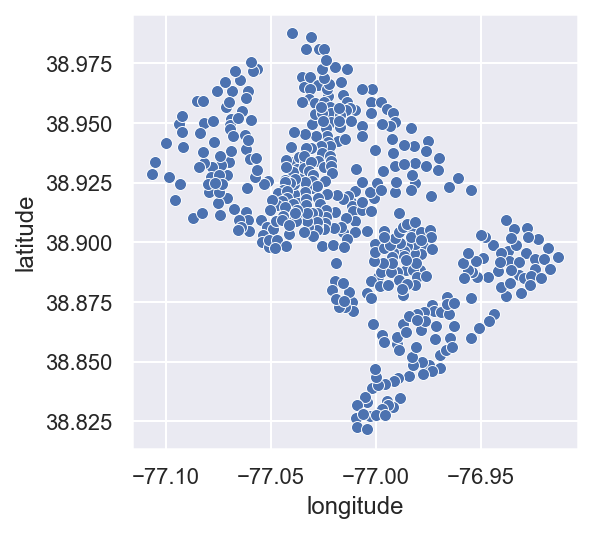

In [43]:
sns.set()
plt.figure(figsize=(4,4), dpi=144)
test = crime[['BLOCK_GROUP', 'longitude', 'latitude']]
test = test.groupby(['BLOCK_GROUP']).mean()
sns.scatterplot(x='longitude', y='latitude', data=test[['longitude', 'latitude']])
plt.show()

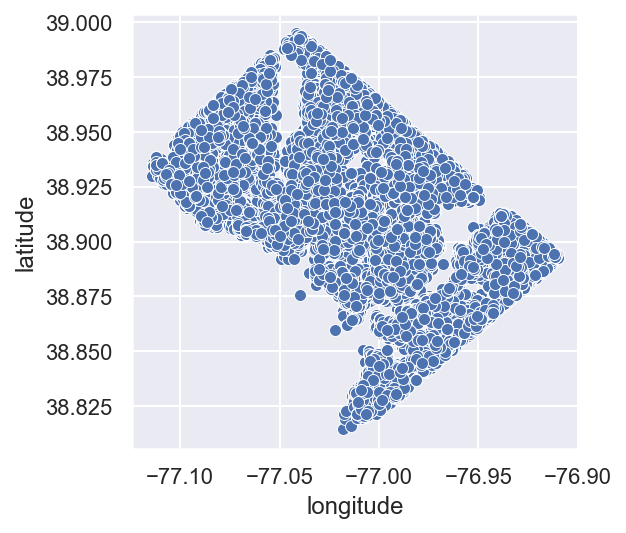

In [44]:
plt.figure(figsize=(4,4), dpi=144)
sns.scatterplot(x='longitude', y='latitude', data=crime[['longitude', 'latitude']])
plt.show()

## 3.1 kmeans聚类

### 3.1.1数据集标准化处理

In [164]:
del crime['REPORT_DAT']

In [167]:
crime_scaled = pd.DataFrame(preprocessing.scale(crime))
crime_scaled.shape

(415774, 40)

In [47]:
xy_scaled = pd.DataFrame(preprocessing.scale(crime[['longitude', 'latitude']]))
xy_scaled.shape

(415774, 2)

### 3.1.2 距离模型

利用 `sklearn.cluster` 中的 `KMeans()` 方法来构建聚类模型

In [48]:
clf = KMeans(n_clusters=46, verbose=1)  
clf.fit(xy_scaled)

Initialization complete
Iteration 0, inertia 17923.512744875432
Iteration 1, inertia 14581.571198215017
Iteration 2, inertia 14073.928620986684
Iteration 3, inertia 13859.021631304491
Iteration 4, inertia 13759.004172517862
Iteration 5, inertia 13648.487406230308
Iteration 6, inertia 13551.958165909999
Iteration 7, inertia 13509.268277848476
Iteration 8, inertia 13471.884174614366
Iteration 9, inertia 13452.285175632693
Iteration 10, inertia 13441.60268892053
Iteration 11, inertia 13427.344095544231
Iteration 12, inertia 13413.50736141149
Iteration 13, inertia 13398.185960978137
Iteration 14, inertia 13385.143890953592
Iteration 15, inertia 13362.740991898541
Iteration 16, inertia 13332.323501971
Iteration 17, inertia 13320.007045653656
Iteration 18, inertia 13310.42236681005
Iteration 19, inertia 13302.030988644894
Iteration 20, inertia 13287.722095921437
Iteration 21, inertia 13264.041275180025
Iteration 22, inertia 13206.587965853543
Iteration 23, inertia 13155.410359341122
Iteratio

Iteration 2, inertia 14561.511840852036
Iteration 3, inertia 14348.299644101553
Iteration 4, inertia 14217.569322313144
Iteration 5, inertia 14119.71798783006
Iteration 6, inertia 14009.41730753908
Iteration 7, inertia 13870.12246209793
Iteration 8, inertia 13764.629674776226
Iteration 9, inertia 13706.183666939907
Iteration 10, inertia 13670.192720235707
Iteration 11, inertia 13655.858316883208
Iteration 12, inertia 13650.464499923484
Iteration 13, inertia 13641.416689157531
Iteration 14, inertia 13636.839420124072
Iteration 15, inertia 13632.588217012704
Iteration 16, inertia 13629.780095751255
Iteration 17, inertia 13624.820877171454
Iteration 18, inertia 13621.156417025935
Iteration 19, inertia 13618.476979850644
Converged at iteration 19: center shift 3.518140228278898e-05 within tolerance 9.999999999999303e-05.


KMeans(n_clusters=46, verbose=1)

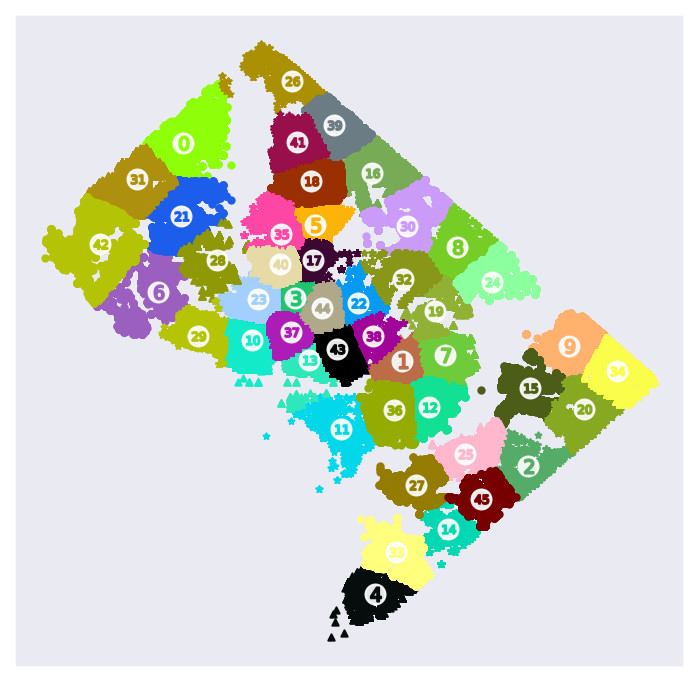

In [49]:
labels_xy = clf.labels_
centers = clf.cluster_centers_
markers = ['o', '^', '*']
colors = pd.DataFrame(sns.xkcd_rgb, index = {0})

plt.figure(figsize=(6,6), dpi=144)
plt.xticks(())
plt.yticks(())

# 画样本
for c in range(46):
    cluster = xy_scaled[labels_xy == c]
    plt.scatter(cluster[0], cluster[1], 
                marker=markers[c % 3], s=10, c=colors.iloc[0, c])
# 画出中心点
plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=0.9, s=100)
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, s=50, c=colors.iloc[0, i])

上图显示了k-means针对犯罪地理经纬度信息进行聚类后的效果，根据分布点的空间分布密集程度，采用minkowski距离函数进行判别，将所有数据点分为46类，分别对应46个cluster，从地理分布的角度来看，模型聚类效果较好。

## 3.2 KNN分类
### 3.2.1 利用PCA进行数据降维

In [168]:
estimator = PCA(n_components=10)
y = crime['NEIGHBORHOOD_CLUSTER']
knn_crime = crime.drop(columns=['NEIGHBORHOOD_CLUSTER'])
pca_crime = estimator.fit_transform(knn_crime)
pca_crime.shape

(415774, 10)

### 3.2.2 划分训练集和测试集

In [128]:
from sklearn import model_selection

pca_crime = pd.DataFrame(pca_crime)
pca_crime.index = start

x_train, x_test,\
y_train, y_test \
= model_selection.train_test_split(pca_crime, y, test_size=0.3, random_state=0)

### 3.2.3 模型训练

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 21)
knn_model.fit(x_train, y_train)

knn_test_pred = knn_model.predict(x_test)

### 3.2.4 模型评估

In [58]:
from sklearn import metrics
print(metrics.classification_report(y_test, knn_test_pred))
print(metrics.confusion_matrix(y_test, knn_test_pred))
print(metrics.accuracy_score(y_test, knn_test_pred))

C:\Users\21548\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\21548\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\21548\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.10      0.07      0.08      3244
           2       0.23      0.66      0.34     10077
           3       0.13      0.14      0.14      5368
           4       0.34      0.14      0.19      3586
           5       0.05      0.01      0.02      2128
           6       0.15      0.13      0.14      7181
           7       0.14      0.11      0.12      4336
           8       0.21      0.28      0.24      8631
           9       0.06      0.02      0.03      2244
          10       0.15      0.02      0.04      1063
          11       0.18      0.04      0.07      2157
          12       0.08      0.00      0.00       792
          13       0.17      0.02      0.04       840
          14       0.19      0.02      0.03      1058
          15       0.21      0.03      0.05      1470
          16       0.11      0.01      0.01       712
          17       0.12      0.03      0.05      3495
          18       0.17    

### 3.2.5 模型性能提升
对于K近邻算法，K的不同取值选取会影响模型的效果。此外，不同的数据标准化方法也会对模型效果产生影响。
本节我们将分别探索K取值的改变和数据标准化方法的改变是否能够提升模型的预测结果。
#### 测试不同k取值对模型效果的影响
我们将分别测试 k = 1，5，9，11，15，21，27 时模型的效果。由于模型整体预测准确率很低。
我们通过观察*正确率（Accuracy）*来对比不同k取值下模型的效果。

In [60]:
k_list = (1,5,9,11,15,21,27)
for k in k_list:
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(x_train, y_train)

    test_pred = knn_model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, test_pred)
    confusion_mat = metrics.confusion_matrix(y_test, test_pred)
    
    print("k = ",k)
    print("\t正确率: ", '%.2f'%(accuracy*100) + "%")

k =  1
	正确率:  29.80%
k =  5
	正确率:  22.43%
k =  9
	正确率:  19.96%
k =  11
	正确率:  18.93%
k =  15
	正确率:  17.32%
k =  21
	正确率:  16.07%
k =  27
	正确率:  15.32%


可见，模型整体正确率较低，随着k值递减，当k=1时模型正确率最高，但仅仅是在测试集上的结果，对于真实的数据选取k=1往往会因模型过拟合导致效果较差。所以这里k=5可以作为性能调优之后的分类模型，但分类效果仍然较差，后续将采用集成模型进行分类并测试集成模型的分类效果。

## 3.3 Random Forest 分类

In [79]:
#使用默认的随机森林算法
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
rf_model = RandomForestClassifier(n_estimators = 10, criterion="gini")
rf_model.fit(x_train, y_train)
acu_train = rf_model.score(x_train, y_train)
acu_test = rf_model.score(x_test, y_test)
y_pred = rf_model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")
# scores_rf = cross_val_score(rf_model,pca_crime,y,cv=10,scoring="accuracy")

In [81]:
result = {
              "k":[],
              "auc_train": [],
              "auc_test": [],
              "recall": []
              }
result["k"].append(10)
result["auc_train"].append(acu_train)
result["auc_test"].append(acu_test)
result["recall"].append(recall)
result

{'k': [10],
 'auc_train': [0.9969179600125069],
 'auc_test': [0.958383106315089],
 'recall': [0.9149336420294923]}

可以看到，随机森林分类算法效果提升显著，在选取超参数为10个分类器，特征选择算法为gini不纯度的情况下：

* 预测分类的AUC值可以达到95.7%

* 召回率可以达到88.6%

接下来我们调整n_estimators参数来做随机森林模型性能的调优，这里将n_estimators从1迭代到20，计算每一次的auc和召回率并可视化。

In [93]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [108]:
def rf_model(k):
    return RandomForestClassifier(n_estimators = k, criterion="gini")

def svc_model(model):
    model.fit(x_train, y_train)
    auc_train = model.score(x_train, y_train)
    auc_test = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    recall = recall_score(y_test, y_pred, average="macro")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    return auc_train, auc_test, recall, accuracy, f1
    
def run_rf(kmax):
    result = {
              "k":[],
              "auc_train": [],
              "auc_test": [],
              "recall": [],
              "accuracy":[],
              "f1-score":[]
              }
    for i in range(1,kmax+1):
        auc_train, auc_test, recall, accuracy, f1 = svc_model(rf_model(i))
        result["k"].append(i)
        result["auc_train"].append(auc_train)
        result["auc_test"].append(auc_test)
        result["recall"].append(recall)
        result['accuracy'].append(accuracy)
        result['f1-score'].append(f1)
    return pd.DataFrame(result)

df = run_rf(20)

C:\Users\21548\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\21548\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


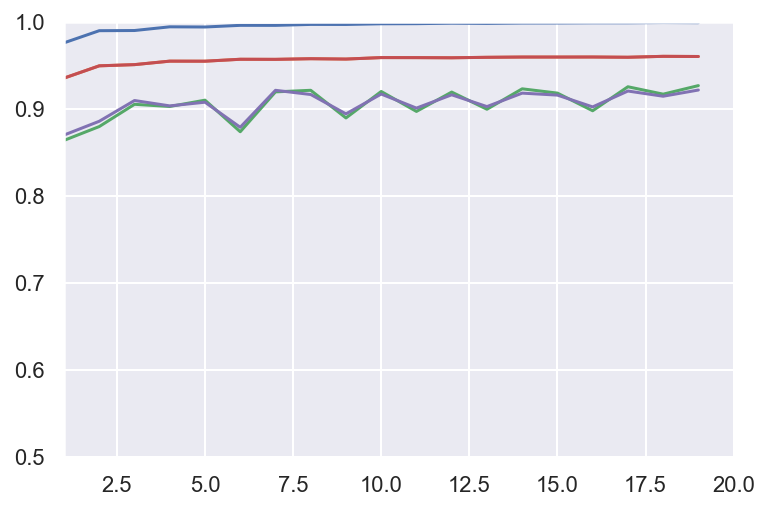

In [116]:
plt.figure(figsize=(6,4), dpi=144)
df["auc_train"].plot()
df["auc_test"].plot()
df['recall'].plot()
df['accuracy'].plot()
df['f1-score'].plot()
plt.xlim(1,20)
plt.ylim(0.5,1)
plt.show()

这里可以看出，在n_estimator从1一直迭代到20的过程中：

* 测试数据集AUC值逐渐收敛到96%

* 平均召回率逐渐收敛到92%

* 准确率逐渐收敛到96%

* f1-score逐渐收敛到92%

模型总体分类效果较好。

# Task 4 Housing Price

## 4.1地形图展示不同cluster房价均值

In [197]:
dc = gpd.read_file("./data/Neighborhood_Clusters.geojson")
dc['NAME'] = dc['NAME'].str.extract('([0-9]+)').astype('int8')
price = inHousing.groupby(['CLUSTER_NUM'])[ 'PRICE'].mean().astype('int64')
price.index.name = 'index'
price.columns = ['PRICE']

In [199]:
# merge two dataset
dc = dc.merge(price, left_on='NAME', right_on='index', how='left')
# dc = dc.drop('day', axis=1)
mean = dc['PRICE'].mean()
dc['PRICE'] = dc['PRICE'].fillna(mean)
dc.head()

OBJECTID                  WEB_URL  NAME  \
0         1  http://planning.dc.gov/    39   
1         2  http://planning.dc.gov/    38   
2         3  http://planning.dc.gov/    36   
3         4  http://planning.dc.gov/    27   
4         5  http://planning.dc.gov/    32   

                                           NBH_NAMES  Shape_Length  \
0   Congress Heights, Bellevue, Washington Highlands  10711.668010   
1                           Douglas, Shipley Terrace   8229.486324   
2  Woodland/Fort Stanton, Garfield Heights, Knox ...   4746.344457   
3                          Near Southeast, Navy Yard   7286.968902   
4      River Terrace, Benning, Greenway, Dupont Park  11251.012821   

     Shape_Area      TYPE                                           geometry  \
0  4.886463e+06  Original  POLYGON ((-76.99402 38.84520, -76.99471 38.845...   
1  2.367958e+06  Original  POLYGON ((-76.97472 38.85287, -76.97499 38.853...   
2  1.119573e+06  Original  POLYGON ((-76.96877 38.86067, -76.96907 38.860...   
3  1.619167e+06  Original  POLYGON ((-76.98726 38.87712, -76.98860 38.877...   
4  4.286254e+06  Original  POLYGON ((-76.93760 38.88996, -76.93783 38.890...   

      PRICE  
0  196766.0  
1  248737.0  
2  176752.0  
3  624777.0  
4  188922.0

In [200]:
centroid=dc.geometry.centroid ## identifies the center point of all the neighborhood shapes 
m=folium.Map(location=[centroid.y.mean(), centroid.x.mean()], zoom_start=12) ## initiaes a map based on the centroid

In [201]:
variable = 'PRICE' 
name = '# average price'
print(name, "colorscale")
print("Min:",dc[variable].min())
print("Max:",dc[variable].max())   
colorscale = branca.colormap.linear.YlOrRd_09.scale(dc[variable].min(), dc[variable].max()) 
colorscale

# average price colorscale
Min: 176752.0
Max: 708468.0


In [202]:
# create df with neighborhood name and variable of interest, sorted from largest to smallest
df = dc[['NAME', variable]].sort_values(by = variable, ascending = False) 
    
# reset index so that the largest value corresponds to row 0 and smallest to row 136
df.reset_index(inplace = True)
leg_brks = list(df[df.index.isin([0,4,9,19,29,49])][variable]) # identify the value of the var by index position
    
# make the smallest value of the scale be 0
leg_brks.append(0)
leg_brks.sort() # sort from smallest to largest
print("Quantiles:", leg_brks)

Quantiles: [0, 348916.0, 411829.0, 515342.0, 624777.0, 708468.0]


In [203]:
print(name, "colorscale")

colorscale = branca.colormap.linear.YlOrRd_09.scale(dc[variable].min(), dc[variable].max()) 
colorscale = colorscale.to_step(n = 6, quantiles = leg_brks) ## sets quantile breaks 
colorscale.caption = name ## adds name for legend
    
colorscale

# average price colorscale


In [204]:
variable = 'PRICE' #active restaurants in Washington, DC as of 9/2019
name = '# average price'


folium.GeoJson(dc, ## GeoPandas dataframe
               name="Washington DC",
                   
               ## controls the fill of the geo regions; applying colorscale based on variable
               style_function=lambda x: {"weight":1
                                         , 'color': '#545453'
                                         ## if variable is 0 map is a very light grey
                                         ## else colorscale applies based on variable
                                         , 'fillColor':'#9B9B9B' if x['properties'][variable] == 0 
                                         else colorscale(x['properties'][variable])
                                         ## similarly opacity is increased if value is 0
                                         , 'fillOpacity': 0.2 if x['properties'][variable] == 0 
                                         else 0.5},
                   
               ## changes styling of geo regions upon hover
               highlight_function=lambda x: {'weight':3, 'color':'black', 'fillOpacity': 1}, 
               
                ## tooltip can include information from any column in the GeoPandas dataframe   
                tooltip=folium.features.GeoJsonTooltip(
                fields=['NBH_NAMES', 'NAME', variable],
                aliases=['NBH_NAMES:', 'Cluster:', name])
              ).add_to(m)

## add colorscale to map so that it appears as the legend
colorscale.add_to(m)

m

根据 __房价地理分布__ 结合 __犯罪分布__ 可以看出：

* 总体趋势为犯罪率较低的西北部房价较高

* 靠近河岸的地区房价较高

* 靠近DC行政中心（presidents' park， white house）的周围地区房价较高

## 4.2 预测房价趋势

In [205]:
test = inHousing[['SALEDATE_year','SALEDATE_month','SALEDATE_day','CLUSTER_NUM','PRICE']]
test['SALEDATE_year'] = test['SALEDATE_year'].astype('int64').apply(str)
test['SALEDATE_month'] = test['SALEDATE_month'].astype('int64').apply(str)
test['SALEDATE_day'] = test['SALEDATE_day'].astype('int64').apply(str)
test['SALEDATE'] = test['SALEDATE_year']+"-"+test['SALEDATE_month']+'-'+test['SALEDATE_day']
test['SALEDATE'] = pd.to_datetime(test['SALEDATE'],format = '%Y-%m-%d')
test.index = test['SALEDATE']
test = test[['PRICE']]
test = test[test.index.year>=1992]
test = test.resample('M').mean()
test = test.fillna(method = 'ffill')

### 4.2.1 霍尔特(Holt)线性趋势法预测未来房价（按月为单位）

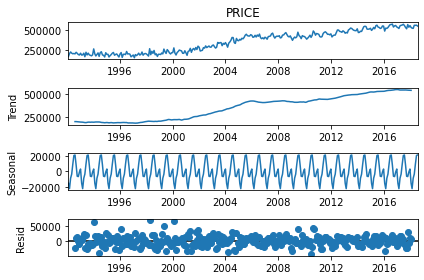

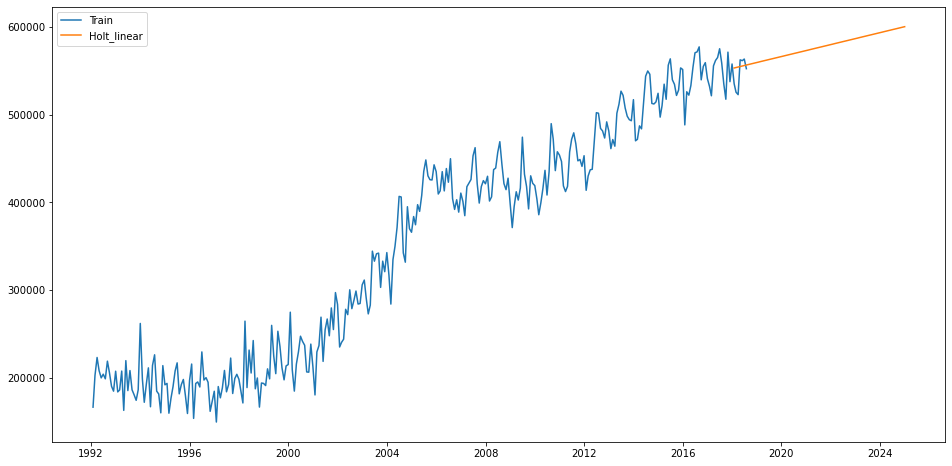

In [207]:
sm.tsa.seasonal_decompose(test['PRICE']).plot()
result = sm.tsa.stattools.adfuller(test['PRICE'])
plt.show()
y_hat_avg = []
for i in range(2018,2025):
    for j in range(1,13):
        y_hat_avg.append((str)(i)+'-'+(str)(j)+'-'+(str)(calendar.monthrange(i, j)[1]))
y_hat_avg = pd.DataFrame(y_hat_avg)
y_hat_avg.columns = ['date']
y_hat_avg['date'] = pd.to_datetime(y_hat_avg['date'],format = '%Y-%m-%d')
y_hat_avg.index = y_hat_avg['date']
fit = Holt(np.asarray(test['PRICE'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit.forecast(len(y_hat_avg))
plt.figure(figsize=(16, 8))
plt.plot(test['PRICE'], label='Train')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

### 4.2.2 霍尔特季节性预测模型预测未来房价（按月为单位）

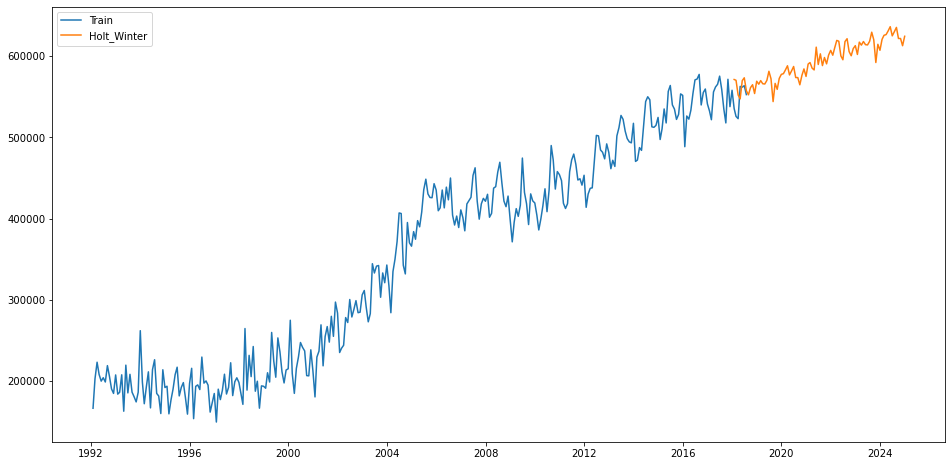

In [208]:
from statsmodels.tsa.api import ExponentialSmoothing
y_hat_avg = []
for i in range(2018,2025):
    for j in range(1,13):
        y_hat_avg.append((str)(i)+'-'+(str)(j)+'-'+(str)(calendar.monthrange(i, j)[1]))
y_hat_avg = pd.DataFrame(y_hat_avg)
y_hat_avg.columns = ['date']
y_hat_avg['date'] = pd.to_datetime(y_hat_avg['date'],format = '%Y-%m-%d')
y_hat_avg.index = y_hat_avg['date']
fit1 = ExponentialSmoothing(np.asarray(test['PRICE']), seasonal_periods=50, trend='add', seasonal='add', ).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(y_hat_avg))
plt.figure(figsize=(16, 8))
plt.plot(test['PRICE'], label='Train')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

下面我们探究一下出售房价随月份和季度的变化关系

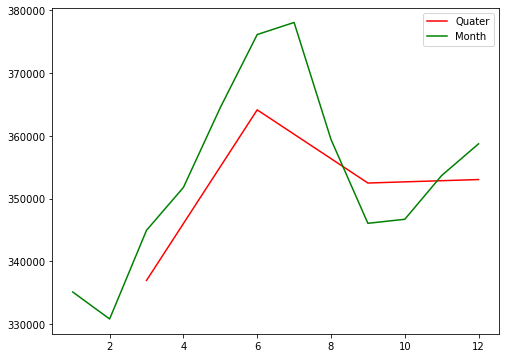

In [209]:
plt.figure(figsize=(8, 6))
q = test.resample('Q').sum()
# 这里/3操作是为了保持两条曲线维度一致
plt.plot(q.groupby(q.index.month).mean() / 3, color='r', label='Quater')
q = test.resample('M').sum()
plt.plot(q.groupby(q.index.month).mean(), color='g', label='Month')
plt.legend(loc='best')
plt.show()

上图显示出：
* 夏季为一年中房价最高的时段
* 整体趋势呈驼峰型

房价预测总结：

* 两种模型都预测了未来一段时间整个DC区域房价的走势（到2025年）

* 两种模型都大致呈上升趋势，且伴随月份和季度波动

## 4.3 房价回归模型

In [213]:
housing = inHousing
housing = pd.read_csv("./data/housing_final.csv",index_col = None)

In [214]:
from sklearn.decomposition import PCA
# 提取变量值和目标值
X = housing.drop(['PRICE'],axis=1)
Y = housing['PRICE']
# 降维
# 提取变量值和目标值
pca = PCA(n_components=10)
pca.fit(X)
X = pd.DataFrame(pca.fit_transform(X))
print(pca.explained_variance_ratio_)

[5.21316228e-01 3.27275825e-01 9.90404960e-02 3.71291392e-02
 1.09289733e-02 2.84058529e-03 1.34474873e-03 7.38123381e-05
 1.30608099e-05 1.01077812e-05]


### 4.3.1 载入评价指标

In [215]:
import sklearn.metrics as m

In [216]:
from sklearn.model_selection import train_test_split
# 30%用于测试集，70%用于训练集
X_train,X_test,y_train,y_test= train_test_split(X,Y,test_size=0.3,random_state=0)

### 4.3.2 决策树回归

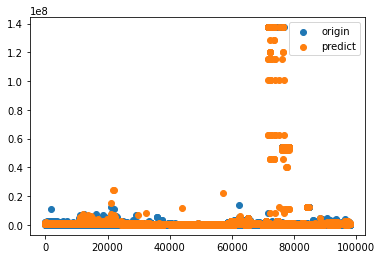

In [222]:
from sklearn.tree import DecisionTreeRegressor
# 构建决策树模型并预测
reg1 = DecisionTreeRegressor(max_depth=10)
reg1.fit(X_train,y_train)
predict_value = reg1.predict(X_test)
# 绘制图像
plt.figure()
plt.scatter(X_test.index.tolist(), y_test.tolist(), label = "origin")
plt.scatter(X_test.index.tolist(), predict_value.tolist(), label = "predict")
plt.legend()

In [223]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict = predict_value
y = y_test
print(f'mean squared error is: {mean_squared_error(y,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y,y_predict)}')
print(f'R^2 score is: {r2_score(y,y_predict)}')

mean squared error is: 12636355580832.15
mean absolute error is: 356617.1973017017
R^2 score is: 0.7294764473392898


决策树回归中：

* 橙色样本点为预测房价值

* 蓝色样本点为原始数据的真实价格

* 测试集随机选取总样本30%

* 数据本身经过PCA降维至10维

* 回归模型$R^{2}$ 分数为0.73，说明模型基本拟合

### 4.3.3 随机森林回归

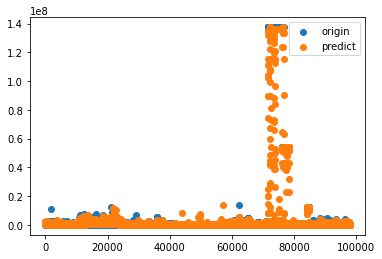

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# # 提取变量值和目标值
# X = housing.drop(['PRICE'],axis=1)
# Y = housing['PRICE']
# 构建决策树模型并预测
forest_reg = RandomForestRegressor(random_state=41)
forest_reg.fit(X_train,y_train)
predict_value = forest_reg.predict(X_test)
# 绘制图像
plt.figure()
plt.scatter(X_test.index.tolist(), y_test.tolist(), label = "origin")
plt.scatter(X_test.index.tolist(), predict_value.tolist(), label = "predict")
plt.legend()

### 4.3.4 模型评价指标

In [221]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict = predict_value
y = y_test
print(f'mean squared error is: {mean_squared_error(y,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y,y_predict)}')
print(f'R^2 score is: {r2_score(y,y_predict)}')

mean squared error is: 8986741959391.098
mean absolute error is: 290787.7702223129
R^2 score is: 0.8076086616787456


随机森林回归中：

* 橙色样本点为预测房价值

* 蓝色样本点为原始数据的真实价格

* 测试集随机选取总样本30%

* 数据本身经过PCA降维至10维

* 回归模型$R^{2}$ 分数为0.81，说明模型拟合较好

回归模型评价总结：

* 两个回归模型都具有较好的拟合能力，其中随机森林较决策树更优

* 从图中可以看出，类似随机森林的集成模型能够一定程度上减轻过拟合

* 在本例中随机森林回归中的每棵决策树更加简单，所以能够一定程度上解决决策树单一模型过于复杂从而导致过拟合的问题

# Task 5 Extra Data Analysis -- Crime Prediction

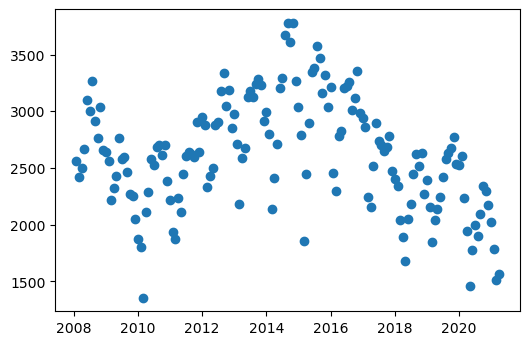

In [142]:
test = crime_pred
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(test.index,test['NEIGHBORHOOD_CLUSTER'])
plt.show()

上图展示了犯罪数据按月聚合后的数据分布。

## 5.1 crime发生频率时序预测

#### 霍尔特季节性预测模型预测犯罪率

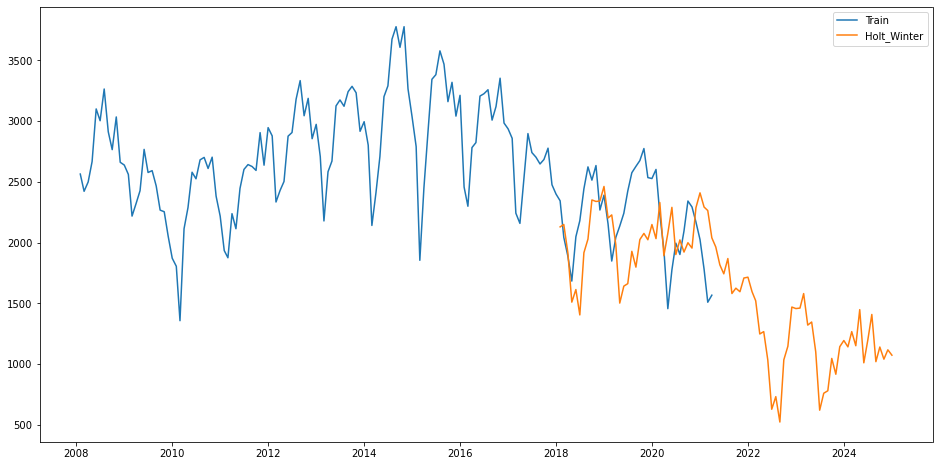

In [145]:
from statsmodels.tsa.api import ExponentialSmoothing
y_hat_avg = []
for i in range(2018,2025):
    for j in range(1,13):
        y_hat_avg.append((str)(i)+'-'+(str)(j)+'-'+(str)(calendar.monthrange(i, j)[1]))
y_hat_avg = pd.DataFrame(y_hat_avg)
y_hat_avg.columns = ['date']
y_hat_avg['date'] = pd.to_datetime(y_hat_avg['date'],format = '%Y-%m-%d')
y_hat_avg.index = y_hat_avg['date']

temp = test[test.index.year<2018]
fit1 = ExponentialSmoothing(np.asarray(temp['NEIGHBORHOOD_CLUSTER']), seasonal_periods=50, trend='add', seasonal='add', ).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(y_hat_avg))
plt.figure(figsize=(16, 8))
plt.plot(test['NEIGHBORHOOD_CLUSTER'], label='Train')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

犯罪预测模型分析：

* 橙色曲线为预测曲线

* 蓝色曲线为原始数据

* 总体呈下降趋势并有所波动

* 蓝色与橙色重叠部分波动具有相似性，一定程度说明模型预测效果较好

# Conclusion

在本次针对DC犯罪和经济数据分析中：

我们首先对数据的类型、字段，进行分布探索，找到了数据集的缺失值、异常值、离群值，并做了相应的数据预处理，对于不同特征的非数值型字段也进行了数值型映射，采用了不同的字符串编码方式，如热卡、哑变量等。

然后我们通过对数据分布的简单探索，得出了一些经验性的总结，比如犯罪类型和房价的时空分布特征，并对不同字段的相关性做了分析，提出了相关性明显的多于字段，降低模型复杂度，在对数据的可视化过程中使用到了热力图、直方图、折线图等多种展现形式。

在我们对犯罪的时空信息进行聚类和分类的过程中：

* 聚类应用了k-means模型将数据集划分为46类

* 分类采用了KNN、决策树、随机森林等单一或集成模型，并做了模型验证，AUC值收敛到96%，f1-score收敛到92%，分类效果较好

在对于房价的预测模型中：

* 采用了霍尔特线性趋势法和霍尔特季节性预测模型，分别对DC地区整体房价进行了预测

* 从预测结果来看，整个DC地区的房价具有明显的上升趋势，并且具有季节性的波动

* 采用决策树和随机森林两种模型进行房价的回归模型建立，并通过评价指标比较了二者的性能

在对于未来犯罪数量的预测模型中：

* 采用了霍尔特季节性预测模型，对DC地区犯罪数量进行了预测

* 从预测结果来看，未来DC地区犯罪数量将波动下降